# OkCupid Profiles Topic Modeling and Analysis
- This notebook explores OkCupid dating profile bio descriptions.  We have a dataset of profiles containing name, age, location, and description.  The data was obtained using an API.  Here, we use a small sample of ~3400 observations.
- Let's start with exploratory summary stats, then see what clusters and abstract themes form when we apply topic modeling techniques.

In [120]:
# code from: https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

import re
import string
import base64
import numpy as np
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS


%matplotlib inline
# from sqlalchemy import create_engine
# import pymysql

In [76]:
# engine = create_engine("mysql+pymysql://[redacted]:[redacted]@[redacted]/[redacted]?host=localhost?port=3306")
# conn = engine.connect()
# sql = 'SELECT * from profile'
# df = pd.read_sql(sql, conn)

df = pd.read_csv('data/OKC_profiles.csv')
df.tail(5)

,Unnamed: 0,name,age,location,profile,id
3454,3454,14880804637768056068,25,"Los Angeles, California",1. My self-summary: What's up looking for good...,3455
3455,3455,17970967172049327033,18,"Los Angeles, California",1. My self-summary: Shy But Crazy When You Get...,3456
3456,3456,7427755961148477906,29,"Beverly Hills, California",1. My self-summary: Let’s see how bad you can ...,3457
3457,3457,peanutslover,28,"Reseda, California",1. My self-summary: ..hi\n2. What I'm doing wi...,3458
3458,3458,11520734543755277993,21,"La Cañada Flintridge, California",1. My self-summary: A down ass girl that is sw...,3459


# EDA

In [26]:
def to_int(x):
    try: return int(x)
    except: return None

df['age'].apply(to_int).describe()

count    2824.000000
mean       22.985482
std         3.005038
min        18.000000
25%        21.000000
50%        23.000000
75%        25.000000
max        30.000000
Name: age, dtype: float64

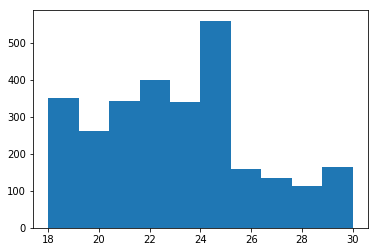

In [27]:
valid_ages = df['age'].apply(to_int).dropna()
plt.hist(valid_ages);

In [66]:
# top_cities = df['location'].value_counts()[:10]
top_cities = [x for x in df['location'].value_counts().keys()[:10]]

top_locations_column = df['location'].apply(lambda x: x if x in top_cities else None)
# top_locations_column[-10:]

top_cities

['Los Angeles, California',
 'Long Beach, California',
 'Beverly Hills, California',
 'Shanghai, China',
 'Whittier, California',
 'Northridge, California',
 'Pasadena, California',
 'North Hollywood, California',
 'Torrance, California',
 'Downey, California']

In [69]:
data = [go.Bar(
#             x = top_locations_column.author.map(z).unique(),
            x = top_cities,
            y = top_locations_column.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = top_locations_column.value_counts().values
                        ),
            text='Count of profiles in location'
    )]

layout = go.Layout(
    title='Top locations distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


- Let's see what the most common words are in the uncleaned bio descriptions.

In [73]:
all_words = df['profile'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

- There are a lot of junk to remove.

# Tokenize and remove stop words

In [93]:
len(stopwords.words('english'))

179

In [82]:
WORDS_TO_IGNORE = []

stop = set(stopwords.words('english'))
stop_ignore = stop.union(set(WORDS_TO_IGNORE))
# ps = PorterStemmer()

def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop_ignore, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [91]:
# apply the tokenizer into the profile column
df['tokens'] = df['profile'].map(tokenize)
df.reset_index(drop=True, inplace=True)

for profile, tokens in zip(df['profile'].tail(1), df['tokens'].tail(1)):
    print('profile:', profile)
    print('tokens:', tokens)
    print()

profile: 1. My self-summary: A down ass girl that is sweet and fun to be with

tokens: ['self', 'summary', 'ass', 'girl', 'sweet', 'fun']



# Visualize common words by location
- Let's see if there are patterns in word frequencies by location.  For instance, do women in Beverly Hills use the word 'money' more often?

In [125]:
LA = df[df.location=="Los Angeles, California"]["tokens"].apply(lambda x: ' '.join(x)).values
LB = df[df.location=="Long Beach, California"]["tokens"].values
BH = df[df.location=="Beverly Hills, California"]["tokens"].values

In [108]:
eap_64 = b'iVBORw0KGgoAAAANSUhEUgAAAoAAAAGHCAYAAAAgIOMGAAB+7klEQVR42u3deXhV1b0+8HcNG2QKQ04YnFGrVisZGB3A2hZBIThACFasE3pltna4t4ND1fb23v6uV8CpoqKtViSISoBItVoVvIQhCdbWoSJWUECSIEEEstfw+yN7x0NMIEACGd7P85xHOTkckp191n73d03Cew9qnrz3cM4J770EIIQQUEo5AK7ma7dt2wZjTPtXX321izHmmMrKyqOfe+65Y40xvTdt2tS7uLi4mxDiKO99WwBHAUj+b1sA7QAIAGH0MAD2ANghhNjuva/IzMzcfvTRR39qrf34xBNP/GTw4MGblVLrvvOd72zWWu/q2rVrzW9LGWMEAKeUckII/lKJiIgOA8EA2HzCnvdeWGsFAKW1hhAirO21paWlWLVqVZf169f3Wbp0aeamTZvOXrVq1TcB9AbQ6Qh8+9sBvNO3b9+3zj///Fe++93vFvbv3/+jtLS0vV5krQ2cc1Yp5aWUPDGJiIgYAFtf4LPWCu+9AiCCIHAAbM3XlZSUYP369Vl/+MMf+nz55Zfn/fnPf+4DIB1Am9reV0oJKSUA+Pj9nHNwzsn4nwYga54ntX2LSf/vAAgppYveO/47Knrv2r6Vyq5du748fvz4vIsvvnjx8OHDt9b4ehCGoVdKWYZBIiIiBsCWHPpEHPqCILCo0ZW7detWrFy58uiXXnrpnFdffXXoW2+9dS6AM2t7ryAIgKpuWh+HSQDSey/2Eeoa5ccSQnhUdfN6IQS894Expubr3h01atTca665Zu555533Xo3qoDLGCKWUYTcxERERA2CLCH3GGCGlVEqpvbp0i4uL8frrrw946aWXLli5cuV3t27dOgi1dOEGQeCjsIdoTF0c9JpqWvJCCC+EcEop75wLrN2ruLkpMzPz2WuuuebJK664ojA5DIZhKKNqKBERETEANq/QZ60VQoivhb6FCxee+Pjjj1+6bNmyy7Zu3Tqk5t+Nxv4Z771P7iJu7odECGGjCmEQhnsdki/T09OfnDBhwowpU6b8I3pOOuc4TpCIiIgBsEkHPiR17cYzaavl5+efMnv27Kvz8/OvRNVEjeTA54QQNvr7Tb2y1zAnZVVl0AohdBiG1T9rt27dlt15553XTJ48eR0AWGuVUsryDCMiImIAbFKMMVJrLVBjAseiRYuOffjhh6/Oz8+/BsAp8fNKKUgpQ2utcM61hOpeg4RB51wQTybp27fvbxYtWvSLnj17AlUTTWzS5BMiIiJiADyiJKKJHEVFRVi+fPnAxx57bGxJScmlAE6qGfqMMao1VPgO+mBKaYQQOhov+P6MGTOyp02b9j4AOOeklJJjA4mIiBgAjwzvfdWqzIDPy8s79qabbrq3vLz8UgCKoe/QD69SyllrFQD07dv3l/n5+b/u1asXwGogERERA+CRCn/eeyWltGPGjPnes88++xIACCGgtfbee2OtZeg71BNXCCulVFE18G9z587Nzs3N/RcAWGtltCMKERER1YKlkgZmrVVSSjtr1qyznn322ZfiSp/33odhKIwxQbx1G4/WIQVtZa310SSQs8aNG/fR6NGjf/Tll1/G2+Ep3twQERHVjhXAhgsksNYGWutw/vz5iZycnM+ibmAbLdVCjXUSC1F9jNu1a7fqySefvOzyyy//BKja5YRdwkRERAyADRL2AAhrbdzdK+L1/ObPny9zcnI+A5CaHEyo8X8tSql4xxPk5ubeOHfu3NlRCBRcM5CIiIgBsN5BL160GVXd5UJKCaVU9c4byR588MF+kyZNygfQUwjhoq5eOoyklDZaPgeJROJ/t2zZcouUEsYYobXmyU5ERMQA+FXQAyDibdQAiHjHDQB1HqC1a9fi9ddfP3fJkiUjX3zxxYsB9AEAIYRP2nOXjsCvNAgChGEoLrroorufffbZW9u1a8dKIBERUWsNgDXDXtR9axGt11dTWVkZ3nzzza4Aznz00UdPrayszCooKDgTwDcAHJP82qgL0iJpuRc6cr9qKaVwzqFjx46Pf/LJJ9empKSwEkhERNQaAmBSN64CIIIgqLX7FgCWLl3aadeuXWc98cQTZ61fv/7stWvXfgvAWQDa1PX+QRC4qm15rfDea55STYvW2htjREpKSsGGDRsuTklJgfdeCCEYAomIiAGwJQW+eN/dfVX3XnrppS4LFy4854MPPhj+4osv9kdV9237OkIeovewABBXD7mWX7MJgdYYozp16vT6xx9/fH6XLl3YHUxERAyAzT3wxRW+ugJfWVkZXnvttdOfeuqpwa+99trwsrKycwH0qPle0Zp9DlVLt8QzShn0WlAI7Nq16+zy8vIbo3PfV63UQ0RExADYHEKfiKt8QRBUV+ZiJSUleOONN85ZvHjxxUuXLv0OgIGoseh1FPYsAMeKXuuglPLWWpGTkzNh3rx5jzrnlBDCMgQSEREDYNMMfEgKfAJAmPz10tJSvPHGG6c/9thj2YsWLboMwNk13yPqxg3jtfsY9lolr5QS1lrMnDnzzKlTp/7DWquVUoaHhoiIGACbRugTxhghpVTRBXqvb3Tp0qXdlyxZMvypp566rKys7LsAOtUIfNWTM1C1LRjDHkEI4VBV7f3ymWeeSRs7duyX3DuYiIgYAI9c4Ntnla+kpEQ/9thj31m2bNnlxcXFwwGcUCPwwXsfxu8BVveo7hAY79CyoaSk5Pj09HSEYSij4QREREQMgIch9Mm6xvItXrz4xAcffPDyxYsXXwGgX/LXojF8yV263HWD6i3eMaRr166r//Wvf/Xv1KkTjDFSa80QSEREDIANzTmXPGN3rypfUVERli9ffs5jjz12RUlJyWWosdByEATWe++stRzDR4d+8kfb9aWkpLy2YcOGb0cLRTMEEhERA+Ch2l/X7osvvtiloKBg1J/+9KdxpaWlw5A0Wzeu8hlj2K1LjUJr7YwxMiUlZemGDRuGMwQSERED4CGIK33RzhvVXbtbt27FsmXLznz88cfHLFy4cAyAbyX/vaTJG6zy0eEOgQs3bNhwCXcLISIiBsADEI/p01qL5NBXXFyMOXPmXLh8+fIrioqKRgHoFn8tqvIZay2cc6zy0RENgZ06dZr/8ccf53C3ECIiYgDcD+ec8N6r5PXUSktLceedd35n7ty5N2zdujUHgIq/xhm71ERDYLxbyL3l5eU/BHcLISIiBsCvi9bp01LK6nF9DzzwQO+HH3745rVr194AoF1S6PPeexN17XLGLjVJSilYa5Gbmzt97ty5M1G1ZqBjCCQiolYfAI0xQmutABgA2LZtG37+85/nPvTQQz8B0Dc59FlrLbt2qRmpGvznPXJyci6ZN2/eQu+9jBaQJiIian0BsGbwW7FiBX7zm9/8KD8//+eIxvUppSCECFnpo2bMKaWktRZz5849ITc392PnnIr2jiYiImodAdA5h2iMnwWAwsLCttOnT7+jsLDwxwA0UDV71xjjvPeah5Wa/Qfjq91CPiktLT02NTWVk0KIiKjF2G+FzjknpZRQStmVK1diwIABPxs0aNDuwsLC/wCgtdZGCOHCMJQMf9RSeO/jit8xp5122hwAkFKiqe6dTURE1CAB0Dknqq550pWVlWHKlCnXDRw4cPuqVat+g6rkZwB4Y4xmVy+1RFG3ry8rK7tm3LhxlwLwiCreREREzVmtXcDW2uru3pkzZ54xffr0pwBkxMHPGMNJHdRaVE8KmTt3brfc3NxtxhilteZ4QCIiahkB0HsPIYQCYDdv3oyRI0fet2bNmslA1YzeMAw96tFtTNSiPiRfjQf8V3l5+Yldu3aFtVYopdgfTEREzTsAJg9wnzFjxuk333zznwEcp5SCc84c4vg+H11IPQAnhPBKqQb5Aay1iLaMi8no35NJ4ZbVSjokUkrrnFMpKSkLysrKRmutOSmEiIiadwBM3vc0Jydnyvz582cBgFLKWmvrk9T2Cnhaa58UvBQAEYbhYf/hgiBI/qND0vZ0NcKjxN7VUAZG+hqttTfGiJEjR/40Pz//d+Ai0URE1FwDoLVWSCn99u3bceqpp8747LPPpkUXNFfL5I54WyyrlIr/XwDQ9Qx4ZQA2pqambjznnHM2WWu/EELsBLATwJfRf7+IAmVbAAGANtF/A1QNwG8LoJ33vqtSKmX58uWdy8vLOwDoCKBT9N8OADofQmCsDovR/sYiutgLhsNWzUsphXMOY8aMuSovL+9JcLs4IiJqjgHQOae2b99ujzvuuLwvvvhiTLQVVm0VvfoEvS0A3rv44ovf8d6XDB8+fP03vvGNT40xG4877rhtGRkZh+0HKysrw5tvvqmUUqnW2m5a69SCgoJu69at6ymE6C6l7PXmm28eV1ZWdgyAowH02t97KqUgpQQA47333Mu4dYZApZSw1mLMmDG5eXl58xgCiYio2QXAyspKDBo06O6ioqJftGnTJrTWVq394pyyttaJjh7A2qysrLd79uxZNHz48L+fdNJJ/+zVq9f6rKysev2bAFQYhg1ytYyqdh5VFbuDHo8VBca2SqljwjDs9eijjx7jvT9z48aN3yopKTkZwCmoqizW9j1wEezWGwIvy8vLe54hkIiImlUAvOWWWy685557lrZt29bv2bOn5tWrAkDJsGHDCk877bTlF154YfHAgQM/TiQS+3pPaa1VzrnkwJg88SOuLjbMlfjry9iI+PkowMZj/Kq/ViM8mvoGxyVLlgQATvnzn/98xquvvjrsrbfeOhvAt3gatfoQyEogERE1rwDYqVOnt3fs2HFm9OedmZmZC84777z8ESNGvDZs2LDP6vp73nttjIn/bJMDXnO5ACZP+kga64coMAoA0FpDCFFnSHzvvfewbt26kydPnnzrRx99dLWU0keLaFPrCoET8/LyHorPK4ZAIiJqyrQQoqJr164vXnXVVf996623vlpLdS+5ohdP/vBCiLDGLNvml36/ukh7IQSSlvRwNYOi917s2bNHCyHUUUcdVRm/5rTTTsOGDRs+9t5XJP1dxVOrddxAWWu9UkrMnz//wZycnJS8vLz/jhaOZiWQiIia7gXs888/R+fOe02YVWEYSiGEjRa6bbUXsqgqKIUQSim11+yX/Pz8k3//+9//YPHixVcDOIGnUquWXAmckJeX9yjYHUxERE05AEbdoDIMQ6mUslzYtmpRbGutCoJgr4kl+fn5p8yePfuq/Pz8qwD0rk7MDbNYNjXzEKi1FsYYTJ48+YL77rvvr9FewtwyjoiIml4AjCdrtPZKRVzt01orANXVvlWrVnW68847r120aNEkAKclhz4pZWiMUVwfkKLPkBFCaOfcrpUrV7bv378/jDEiaWF0IiKiJkEKIdCau3iNMcJaGwghoLV2AMLS0lJMnTp1ePfu3QsGDBhQsWjRohkATlNKIQiCUAjhrLU+DMMgWiyb4Y/gvddKKQOg3a233vrz6GlWhYmIqMkRtSyj0uIldfHG6wcCAB544IFvPPzww5PXrl17Hap2Fam6gmsdRos+82JO+/5ACRHvoPPZ9u3be6SkpHDPYCIianJka/lBo2qfdM4FUkofBIEBYNeuXdtm8uTJNwkh3pk8efL7a9eunQ6gUxAEXkppAHhjTMDwR/U8z2TU5dv9iSeeyAIAYwxnhRMRUZPS4iuAtU3oKCsrw1NPPTXwrrvuurm0tHRc/FqlFIQQobVW1bIPMlH97qqkDJ1zQUpKygvbt2+/FIDy3lvOCCYioiZzrWqJP1Rc7QOQXO3zCxcuTLvkkkt+kUgkNk6fPn1FHP601lYIYay1iKp9DH90KDcdWmuNioqKSx544IEzUTXMgFVAIiJqMlpUBdAYI6I1+6q3KCktLcVdd92V/dRTT/2wrKzsgvj5IAhgrTXOOQVO4qCG/mB9NRZw19y5c7vl5ubuds5JKaXj0SEiIgbAQ5S0fItE1b6+AIAHHnjgpGhCxw2IJnRIKSGlZBcvHa4QaL33CsDbO3bsOKtjx45wzkFKnnpERHRkNdsrkXNOhGGohRAiWr7FFBcXY/LkyT8QQvxt8uTJ69auXXsLkiZ0OOc8u3jpMN6cqDZt2lgA3/rhD384NDpv2RVMRERHXLOrADrnBAAVzdAFAOTn5/f69a9/Pb2wsHAqgPYAJ3RQE/mACRHvEPPhzp07T27fvr2qrKz0QRA4TgohIqIjpdkEI2OMQDSpQ0ppSktLMWvWrMGpqakvjho16tPCwsJ/B9CeEzqoKfHe6yAIHICTfvSjH10GwLZp08YJIWQYhoExRkY7yRARER02Tb4CGG2lpRCN7ystLcXtt99+wwMPPPBLAMcDX43ti9ZbY+CjJpcDEU00mj59+uXXXnvtc+np6TVfE4RhCCGEVUqxOkhERK0zABpjpNZaINqpo7CwENOmTfvRypUrbwXQGQCCIPDWWsuZvNTcpKWlvX7eeec9c+21176QnZ39Sc2vW2sD55yPAqFnICQiohYdAKOKnwDgouDXdvr06T8vLCz8DwBtAEBr7ay1YPcuNTNea+1q2RlkY3p6+otDhgx54eKLL35l+PDhX9b4urTWKuecV0pZIQQDIRERtYwAWLOrt7CwsMv06dNvLywsvDl+jdbaWGslgx819yAopbRKKe+cC6y1Nb/+7vDhw5dcfPHFzw8ePPiNjIyMml9XYRgKpZTlHsNERNQsA2Atwe+o6dOn/7awsHB6cvCLqiYse1CLC4NCiLiyJ51zqpZAWDhy5MjnrrvuukWDBw/+eyKRYBgkIqLmGQCdc0JKmRz85PTp0+8sLCz8RVLwC40xmsGPWlkgjMf9qTAMa1a7v0wkEgXjxo17+Pbbb/9zjTAYhGHoGQaJiKjJBcBo5w6ltbYAsGLFCtx8880/LSws/DUAHQU/VvyIvh4IgzAMk7+2KzMz80/XXHPNQ1dcccXqtLS05BuswDnHGcVERHRkA2AU/LTW2gBAeXk5brjhhikLFiz4LYAODH5E9fjACuGEEE4ppcIwTP6clGZmZj5x9dVXPzJ+/Ph3U1NTq78QzSi2WmuGQSIiOnwB0ForlVIegN+1axduueWWSx966KHfA+geBT9rjJEMfkQHFAbjsYO6RmXwo1GjRj0+YcKEx7Kzszck/5UwDBW7iImIqFEDYM0lXR566KH0W2655fe7du0aCABKKRcNeOesXqJDC4MuCoM1u4n/kZ2d/ciECRP+MGrUqLKk5wNjDLuIiYgYABuO9x7OOaWUsgCwYMGCbjfccMMD5eXluQCgtYa11nE5F6LGCYNaa1tziZnU1NQ3rrzyyv+59dZbX0iaPBJXBY2U/DgSETEAHqSou9cBwMqVKzF16tRfr1y58udJwc9473Uj/TzVA+adc8J7H++zyhIHtUbJn4fAORc/v2PAgAEP/fKXv7w/Ozv7X/GT0WuM1prdw0REDID1Ey3rUt3dO3369Etmzpz5BwApACCljLdsa/ALXHTBqmsNNQRB4AGYeAYyK4/UGsNgtPj0XpNHEonE61dcccUdt99++6tJE0e0Mcaxe5iIiAGw7qvK17t7e9xwww1PlpeXfw9o8Jm9+1sjDQD+OWjQoGUfffRR982bN2cAOKaWQOi895ZhkFrlhz4aL1ijKrh+8uTJv77++usfzczMrH4pJ40QETEAfo21ViilAMBv3rwZo0aNum3VqlW/ioKfN8Z4HNoEj/oEvr8PGzbslVNPPTU/Ozt72dChQ3clf3Ht2rX48MMPv/XHP/6x/0cffXRBcXHxpQA6JYVBHw2aZ6mDWh0ppalRFdwzcODA+37xi1/ck52d/WnyfRMXmSYiYgCEtba66jdt2rRvz5o16ykAR0cXlYPt7q1P4Fs7bNiwl0aMGLF48ODByzIyMkzNFzjngugi9bWvlZWV4fbbbx+5fv36s5csWXIlgBN4GlCrbwiqqoI+qtYDALp16/bSr371q1/n5ua+xkWmiYhaeQCMxvoBgF+9ejWys7Nnb968eQIAKKWstbbe6/kJIaoDX1RhqO1lq4cNG7Z0xIgRSwYPHvx/GRkZvpYwGjjnPAAXL3Yb/VzCWgvvvRJCCK01AFT/I9u2bcNtt9126X333fckgA5Jf4+otfJaa1OjezheZPqx8ePH/4OLTBMRtbIA6JyTUkoHALNmzRo4bdq0hQC6K6XgnNvfsi4+CnxOKeW994ExprbX/d+wYcNeHDFixNLBgwcXZmRkoK7Al1QtPKAAG1UvhZQyBIAFCxa0HT16dKkQoqP33oHrEhLVOmkEwIZRo0bNmTBhwuPZ2dnra34uvfesDBIRtaQA6L2XQgi3adMmZGdn37NmzZofAlVjiJxzuq7AFy1OizoCn01LS1s+YMCAJUOHDn3p/PPPL2rowLefMAjn3FFa690DBgyYuWrVqqlHHXVU5e7du9vw1CCKGom6F5n+Z3Z29pwbbrjhiRrjBbm2IBFRcw+A3nsIISQAN3/+/O45OTn/B+AkKSVcVR+RTAp8cUATzjldy5IsOxKJxJtDhgxZfOWVV746ZMiQt5MWpI1Ja61qjMBXm8rKyqBNmzbh8OHDf7Z06dLfJP/o4MQQoq+FwdoWmQbw9siRIx+77bbb5vTv3//zpJssri1IRNTcAmAU/gAAU6dOPfu+++57E6he2kVGF4N9rcG3KSMj4/XevXsXjB8//rUhQ4Z8VFvgM8Yo7/1hCXw1RWMa/d///veU//u//xu0ZcuW7b/85S9XtGnTBt77yjgEGmN0tKg0EUUV/trCYCKRWHDrrbf+1/e///2VSZ93ZYzx7B4mImriATA5/OXk5Nwwf/78h6WU0Frvds4dVcf4vfczMjL+Onjw4CUjRox4fdiwYdtqeY0yxkjvfdw97JvaBSEtLe3+0tLSSTw9iOodBm00izhIev6j7Ozse37xi1/8fuDAgZXxk2EYaq21YRAkImqCARBVlS+fm5t787x58/63jtesGTp06F+ys7MLTj311P8bNmzYnlpeo6NB5HF1zzfFht97L8Iw1G3atAkBYOHChSc++uijF1prIaW0+fn5MwB0kFKGSilYa0UdYx+JWnUYjCaP6OTxgpmZmY9fd911d06ZMmV9chDkOEEioiYUAMMwlEEQuD/+8Y8n/eAHP1gXPf1pIpF4d9CgQX/+3ve+95fzzz9/dW0TNhAt55LUndusxv5ElU+BqjGA1R588MFvTJo06f3k56JxkBwrSFRb41L72oJL7r777l9MnDixJH7OOaeFEKwIEhEd6QBYNRxP+NLS0javv/76aaeccsrbffr0qTXI1bYGX7MvYXgPY4wEoOKgp5QKL7nkkl8uXLhw/OjRo19ctmzZGVu2bBka/xWGQKK6P1I11xZMJBIrrrjiip8n70FsjNFKKQZBIqIjFQD3Ie7OPSITNo5kIKzt57z55puHzJgx47UaITA+oLyKEdUgpTQAdNIi0+/edNNNP73nnnvy27VrB+CrHggeLSKiIxQAvfcinu0b7/nbWu/Oo+OkhBDOGKO11g6AvfTSS8e88MILeUopb60VUbcwzyyi/QTB5HGC7dq1W3XPPfdMuummm1bHL3HOee47TER0BAIg1R4EhRCw1opofBOCIFgP4MRoweutAD4EMBCARdSNTES1NEBVN5cyXlUgNTX1+V/96leTJk+evAnYe89xIiJqwBtxHoIDvmABAOIlL7TWGD58+AtxOBw5cuSN3bp12xq9lumaaN83VNIYAyGEkVKirKzs0ilTpnzar1+//928eTOi8KeccxxSQUTEANhkLl4AgHbt2r0HAGlpaYvy8/Of//LLL4dHL2H1j6h+nyXtnIu7hrFmzZqbe/Xq9a+ZM2d+C4CVUnrnHNsrIiIGwKZx3QKAnJycIgArly1blg0Au3fv5vqARAch2kLSR5W/46dPn/63fv363bZp0yZIKR2qqoE8UEREh4hjABvjoEZdv0IIz+3jiA76c+SklDLaZm7t3Llzs3NzczcAgLVWKqWYBImIDhIrgA1HJx3Pf0X/ZbomOkjee5lUDUwfN27cx6NHj560e/duKKWctVbzBpaIiAHwSF+sjLVWAcCpp576BgBw9iLRIRPWWiWEsACwYMGC+7t27frK888/3yFeNNpayyo7ERED4BG6SgkRbwuHH/3oR/8TBUANVgGJGuIGS6FqRxG/e/fuCy677LIdN9988+XR58zHN19ERFTP3MIulAa9SFUvE9OpU6fnv/jii0t4VIga+K5VSuucUwDQs2fPeYsWLcrt27cvAIhoJjEbNSKi/bWlPAQNmKarqoACAD755JNLp0yZchmqFoMGWAkkahBR+PNKKWzevHlsv379tk2bNu08AJ7LxRAR1TOzsALYuI499tj5n3zyyWgpZeicC3hEiBrwDlZK45zTANCvX797Fi5c+KNevXoBVcvFWCmZBYmIam0/eQgax+7du9sAQEZGxmoAiPZSJqIGFIU/p5TC6tWrbzn66KP/+cwzz5yCqsWjYa1lG0dExAB4+MRrlA0ePPjl6CkuDk3USO2YtTaedX/KuHHj/jl69OhJu3btglLKGWN490VEVAO7gBuJc05IKf0XX3yBTp06bQbQQwjhvPcM3USN1aAlfcZSUlJefPXVV0dmZWVZcIIIEdHed848BI10YKX0xpigY8eOmDBhwmQA0Frz4kPUiKLw57XWvqKiYnjfvn2/mDZt2gWIJogYY9jmERGBFcBGFVcBd+zYgZSUlPcAnBoEwZ4wDNvy6BA1+k1Y9XIxffv2veeVV175UUpKCqy1iou0E1GrbyN5CBr1AuSttbJTp054+umnzwYAhj+iw3YDpgA4rTXWrFlzS8+ePdc899xzbaPwp3jzS0QMgNRooskgYty4ceWzZs0648wzz3w8Coc8OESHoY0zxkBrbXft2pV1+eWXl86aNetbAKwQQsTrdhIRtTbsAj5MkncJEUL8E8ApnBRCdBiTYFKX8OjRo6+cP3/+nwDAGCO11o5HiIhaVZvIQ3CYkrYQ2L1791EA8N3vfncJAGitOQ6J6DCJu4SFEHj22Wef6t+//z3bt2+H1trFwZCIiAGQGlw88Pyb3/zmX+JcyKNCdHjbPO+9l1Ji9erVPzzhhBP+unr1akgprfeeIZCIGACpUVgAGDNmzBvRnzW4RzDR4Sacc9Bau+3bt5/fv3//Tc8++2xPIYSNAiKPEBG1/IaQjd3h470XQggPAEKIzwCkcRwg0RG8A04aFzh16tSzZ86cuQL4agknHiEiarHtHw/B4c2AiLaESyQS/xcFQY4DJDpCnHMq/gzOmjXr/3Jycq6JgqH33nOIBhExANKhE0IgDEMBAAMHDlwFAEpx2BHREb0rqxr754QQmD9//pz+/fv/1+effw4hhA/DkG0kETEAUsPp3bv3qjgX8mgQHfm2MGlyyE+PP/74F3bu3IkgCDhDmIgYAKlBWAC45JJL/hH9mRNBiJqG6skhO3bsGNW9e/e/LViwoK2U0gJgCCQiBkA6JB4A9uzZsxGoWiCaiJoOY4wUQtgvv/zyW6NHj94yf/78k6MbN84QJqKWc8fLBu0wp7+9ZwLvAdBGCMEB50RN7e5YSueckwCQk5PznXnz5r2KqErIGcJE1OzbOB6CI+qL6L/choqoiYnCnxNCIC8v75Xc3NxJADxnCBNRS8AK4GFWRwWQuxAQNeEsKISQ3nt07979f99///1bOnfujDAMZRAEvHkjomaJFcDDzNqqZf+KiooAoI1SClwImqhpt5Pee6+U8p999tkPjzvuuPx4hjBv3IiIAZDqJe462rx589EAICV/BUTNgLDWCiml27Fjx8ju3bu/tWDBAiWEsNZahkAiYgCk/VIA8OGHH34r+rMB1wIkahacc/EM4bNGjx69ZcGCBccppThDmIgYAKl+XnjhhTOj/+VVg6gZ8d4rKaUDkDp69OiPp02bNghV4wSFcxwSSEQMgFQLIaqKfW3btj2DR4OoeYorgUDVHsJjxoy5ElUzhMEZwkTULPIIuy0Oa+UAQggNwAgh/grgfCGE8d5rHh2i5pkFlVLSWovLL7/8jj/84Q+/6tChA5xzgmsFEhEDIMUBMHkJmA0AjhVCOM4CJmreH21RtZo7OnToMPvTTz+9MSUlBcYYqbVmnzARNUkMHkdONx4CopZzIx0Egd+5c+cNxx133IKKigporV0YhmxjiYgBkPa+aACA1trwUBA1f2EYCq21r6iouOy44457jWsFEhEDINUmiC4abXgoiFoGY4yQUrqKiooh0VqBiNYKZFtLRAyABADQAHDuuedeJ6XcHT3HAZlEzVyNtQI/mj9/fgellDPGsBJIRAyABHfeeectWrZs2Rzn3AcAEC8rQUTNW7RWoAVwQk5Ozsfz58/vobW2ABQn3hERA2ArvC4kHfPdX3755UcAcOaZZ74DAEopXhmIWsodnnNKCOEAdMvJydk4a9asMwFYIYTkgtFExADYiggh4JwTADBlypTrr7766tkAcMwxx6yJv05ELeiOz/t4wWg9bdq0t0ePHn0pACelhDGG7S8RHblMwu6II2/q1KmX33fffc8GQRCGYRjwiBC1OMkLRv/yySef/HW7du1gjFFKKcubPyI63HgHeoQYY+SuXbsCABg9evSG6GkOEidqoW2ttdYLIbBgwYK7e/bsWbBmzRpora2omibMBEhEDICtgdbaRYPCUVpauiHp98GSLFHLJLz3iNYKHN6vX7/y+++//xwAPhr/q40xDIJExADY4q8G0bZwJ5988mYA4MBwopYvXisQQNcpU6Ys79Wr12OrV69WAIzWOg6CksNziKjR70jpyKixN/AWAN25NzBRq1E9LhBAOHDgwF/MmDHjdwMHDqxun8MwVEopK6VkQ01EDYpB4whnwKTfwbr4osDDQtQ62l9rLaL1AoPCwsL/HjRo0I6zzz77N/n5+UcD8EEQmCj8BawKEhEDYAshhEC8O8C3v/3ttQAQdQERUSvhnFMAfDQmuOOKFSt+NmrUqE8SicSr06dPH15aWgoAodbaCSFgrQ3CMJTee44XJCIGwOYqvqPPyMj4C48GUeu9H4xuBp3WOpRSoqys7NszZ84sSEtL2zpgwIBfL1q0qDcAKKXCIAicEMJHYVDHgZAVQiJiAGw+LAAMHTr0zejPATgTmKjVtsnGmMA556WUJggCDyCxatWqn2dnZ38ohHh31KhRt+Tn5x+bFAZNHAiFECoMwyAMQ22MYSAkorrvOtlAHFnOOSGl9Fu2bEHPnj1LAaSiahwgwzkRQQjhlFLWex9EE0ZiHw4fPvz5U0455S+jRo1aMXTo0PI63iIIwxBCCBstN+O58DQRMQA2jRAYSCnDs846a/bbb789QWsdGmO4IwgRJfNCCKu19s65mmEQALYlEokVgwYNeuV73/vesgsuuGBVnz59bC3vo8IwlACsUspzhjERAyAdIWEY6iAIzMyZM78zffr0vwRB4MMw5C06Ee0rDMYTR4RzTtcSCAHgvfT09NeHDBlSMGLEiOXDhg37rJbXBGEYei43Q8QASIdZ3A1cUVGBzp07hwA0qsYBMgQSUb0DYdRd7PFVla+mstTU1GXnn3/+0iuvvPLlwYMH/zMtLS356yoMQ8EwSMQASIcvBAZSyvD0009/5L333rue3cBE1ACh0CqlvBCirirhp5mZmXnXXHPNH6+44oo1NcJgYIwxXJqKiAGQGlHcDfzII4+cdcMNN7yltYYxhgeGiBoyEMahELWMI/wiKytr4dlnn/3kHXfcUZBIJOLnlTHGa625SD0RAyA1eMvsPeKZeUKIdwGcJoQw3nvNo0NEjRUIlVJWCBGEYZj8tc8HDBjwu5kzZ94zcODA3QyCRC0PlxppKklcCIRhGADA9ddffysAaK35+yGixiwASGNMvEyM01qbIAgcgC4rV6789aBBg3YNGjTod4WFhR0A2Cj8KWMMxycTtYAGgEehiYgng3z55Zfo0KFDBYBOQgjnvWcQJKLDeUPqlFLOGFPdAzFw4MB7ZsyYcfvAgQO/iJ7SzjlOFiFqphgsmtIvQ0pvjAnat2+PCRMmTAcArdkDTESHV1QZ1KjaozgEgMLCwlsGDRq0Y9CgQb8tLCyUAIyU0ltrlXOOFUGi5najxwpg0xJXAXfu3ImOHTtuB5DCKiARHelMqLU2SSsThP369fuP/Pz8e3r27Bm3XVoIYbjLCFHzwFDR1H4hVVVA1aFDB1x//fXXAoBSii0qER3RYkEU/rzW2gAIVq9e/T+9evUqmzx58lVlZWWQUhohBIwxmoUFombwoeYHtelxzkFKiT179qBz587Fe/bsyZBSGucc+4OJqCnwSilvrY2LCOtvuummKffcc8+Sdu3aAQDCMJRaa8eKIFHTxApgU/ylSAljjG7bti3uu+++y6Ln4t1BiIiOePHAWiuFEC6aNdz7oYceWpyamrryoYceGgAAQRA4IYQMw1Cy0EDUBD/E/GA24Vts76UQwmVkZNy1du3aXyqlXNIdNxFR07iQVM0alvHi9ampqUvvuuuuyRMnTlwX39daa6GU4hqCRAyAtD/xhJDS0lKkpaWtB3CiEMJ67xWPDhE1wSBohBDaORcHwWfuvPPOH06aNGlTHASNMYi2p+PFh+gIYjWpKf9yoiUWEokEZsyY8Z3oOQV2BRNRE+S919EYZiOlRFlZWe7kyZM/7dWr16OrV6/uBsBF4wI9AB2GISeMEDEAUh0h0AJQ06ZNWz9ixIifsBuFiJo651x1EFRKYfPmzdf179+/LCsr6/cPPPDAidHLTBAERggBa63mWoJEhxe7gJtHYyqklN57jyAI1lhrs6SU1jnHrmAiauq8lNLVaK8+6dOnz8J/+7d/mzVp0qR3agRHq7XmhYmokbEC2Bx+SVVrA0ohBJ577rkLAEAIwa5gImoWhYYo/HmttVFKAcAxb7311sTJkyf/QwixduLEidnl5eWQUpoo/AXcb5iokT+YrAA2H845LaU02dnZVy5atOhJrbUzxjDEE1Fz4oUQXillvfeBtTZ+fuOUKVN+de211z6SlZUVP6eMMV5rzWEvRAyArToAQkopjDE+kUgUbN++fTi7gomoWV+EhDBaaxWGYVzx+2LgwIG/nTFjxn8NHDjQRM/Fs4e5sDQRA2DrZK2VSin3t7/9TfTp02ePlDLw3nOvYCJq7kHQKaW8Mab6hnbgwIH/b8aMGXcPHDhwe/yyMAyVUspIySaP6FDwE9TMKKWcMUadddZZfsqUKYOjqqAExwMSUTPmvZdR+HPRfsMoLCz88aBBgz7v27fv7Pvvv/9oAD4IAiOljCeMsBxIdLA3XawANsuGEkIICcBlZ2f/eNGiRb/jeEAiamlNndbaGGOC+InU1NT822+//e4rrrhiZSKRAAA451S0XBYRMQC2fPHSMNZapKam5m/fvn1ktNQCQyARtbQgaOO1BSP/nDhx4m/uvvvux7t16wZU7U3soxnGRMQA2LIZY4TW2r/11ltIT08vA9BNCMHxgETUIoOglNIqpXQYhvFzpZMmTcq9//77XwEA773gFnNE9cOg0Ixprb0xRvXp0wczZ868AADHAxJRSyWcczoMQwghXBAEDkDigQce+Mvll19+686dOyGE8OwFIarnB4oVwGZ+S1w1HlABsBkZGf+1du3anyqlrLWWfSFE1LIvYEI4KaW01qJDhw5/2LRp09WdOnWqXi2BR4iIAbBFi8cDbtu2Dd26ddsJoD27gomotQiCwIdhKDp37rz8/fffP6979+7w3ishBCeHENWBAaEl/BKrtooLunbtigkTJvwIALTWPDBE1CqEYSiEEG779u3n9ujR4/158+a1FUJY733AIgdR7VgBbCHiKuDOnTvRsWPHLwB0YBWQiFrZzXC8M1LZvHnzzsrJydkEANZaoZTixY4o+fPCQ9BiGj5vjAk6dOiAG2+88cdA1SQRHhkiakU3wkoI4QCkjh079tPc3NwrAEAp5a21ycvIELV6rAC2IPGyMP/4xz9w5plnGiGE8t47Bn0iam1ZMG73evXqtSA/P390375945CohRCGewpTa8dg0IJorb33Xp9xxhnIzMy823sPrTVveYmoNV7bvJQSmzZturxfv347pkyZklNWVgYppRFCIAxDzQIItWasALYwxhiptXbFxcUqKyvLCCHgq37JvN0lotaXBL8aFwgAf5s5c+ZNU6dOfTP+urVWCyGslJIXQ2p1d0nUgmitnfdeZWZm2gEDBjwUVQENjwwRtUZR+HNBEHgAZ02bNm15amrqkoceeqgPACiljJTSO+cCYwxvlKnVYAWwBQrDUAZB4AoKCrpefPHF5UopWGtZBSSi1n3BE8IJIWTSZJDim2666Y7f/OY3C7t27Ro/p4wxXinlOE6QGACpWYl2B5EAXGpq6pPl5eVXSilD51zAo0NErV00DlBbW71O9Kbs7Oz//sUvfnHfwIED4x4TEYah0lpzwggxAFLzEW+FVFJS0ikzM7OCYwGJiGpcAIUwWmsVhmF1u5iZmXn/dddd97spU6b8K34uDEPNIEgMgNRseO+lEMJlZWXdX1xcPElrbYwx3CKEiGjvIOiUUt4YU72Herdu3f5y9913/8fEiRNXJwVBqbVm1zAxAFLTljQjWGdlZYWsAhIR7fu+WWttnHNBPE4wNTX1tbvuuusnEydOXBW9RlprIaVkEKRmjbOAW7BoRrDOzMw0mZmZ/8l1AYmI9kkYYwLnHKSURkqJsrKy8ydNmrQykUi8+MADD5wEwEUTRKQxRrKIQs32ZOfJ27LFu4MUFRWhb9++8S+bu4MQEdWDlNIAqN5GrmfPnn9YtGjRD/v27Vsev4ZjBKlZnts8BC1btDuIysrKwqhRo24GqvbF5JEhIto/55yOK4JKKWzevPkH/fr1K0tLS/vD/fff3xsAgiDg7iLU7LAC2DoaMCGl9GEYok2bNpsA9BRCGO89J4QQEdWfl1K6pJ1F0K1bt6V33333zydOnFgUP8fJItQcsALYGn7JUnpjjAqCAFOnTh0NAEopxSNDRHRARBT+fDxGsLy8fNikSZPWpKWlrb7lllsuAIAgCJwQQlprmQCp6Z7MrAC2ktvWqsWhBQDftm3bP1dWVg6tsUcmEREd+A32XmMEE4nEX3/1q1/dNGnSpPeil2jvPccHUtM7d3kIWknSFwLx3WheXt7YKBQqALwDICI6SMljBKWUKC0t/fbkyZPf7dWr15MrV65sD8AIIWCM4fWWGADpyFBKOQBy1KhRn2dmZt7mvUcQBFwWhoioAYNgNFnkyoEDB35x+eWXX79r1654CS7pnGMpkJoEdgG3vkZKSCl9aWkp0tLS/gngFCGEjaqBRETUAKSUxjmnAaB9+/Zrfve7342bNGnSBwBgjFFKKctuYTqi5ygPQatrlLxzTiYSCcydO/ccAM57r4QQrAQSETXczbYG4JVS/ssvv+w7efLkf/br1++/t2zZAq21FUIIThIhBkA63CHQee9lbm7u1nnz5p2VdC6wHExE1HCEtVYIIYxSCmvWrPlJz549t06bNu17cTi01ir2xNEROTl54rVe1lqtlDLjxo274plnnvmTlBLxTDYiImpQceCTANCzZ89nFy1adGXfvn33oGp5GUgpeUEmBkA6DK1R0tIwaWlpC0tLS7O5NAwRUSNedIVwUkpprQUAM23atFEzZswoiG7KlVLK8igRAyA1ujAMZRAErri4GFlZWdwrmIjoMEieJNKjR49H165dO6FHjx4AoJxzVko2wdTI5yAPQesWBIHz3uvMzEyMGjXqKgDgJiFERI0rCn9OKYUtW7Zc37Nnz40zZ848C4CVUnLdQGp0rAASorEnqKysRNu2bd8FcBr3CiYiOjySh95kZWX94tVXX/1NSkoKwF1EqDHPOx4Ciu42dZs2bTBz5szxAPcKJiI6jDfhSgjhtNYoKir6dc+ePQsXLFjQDdEuIlw8mhoDK4AEYO8JIW3atFkahuGFUsrQORfw6BARHZ6mWClVvW1nbm5uzty5c+cDgDFGRruJEDUIVgCp6k6g9r2CA3BtQCKiw9YUW2uFlNICwDPPPJPXo0ePWTt27IDW2nGFBmIApEYR7xV8ySWXbB87duwl3nsopQRDIBHR4RMFPa+UwmeffTalZ8+eKxcsWHBUFAyrF442xgjvPbuH6eDuNtgFTMmirmAJwGVkZPxm7dq1P1NKWWst7zyJiI7AjXm0ePSuvLy8vmPGjHkHVcUbdgfTIWEFkPa+I6gacOwB4LXXXvu51rrYWqviLgkiIjp8rLVSSmkAtMvJyfnH2LFjvxuHv3/7t3/rt2rVqtTodawEEgMgHeJJIaU3xsjOnTvj+eefPx8AvPcK7AomIjrs4jUDhRDIy8t7+fLLL78RADp06JC6du3a7lEbzQNFB4RdwLTPRkdKafr27furoqKi29gVTER0ZJtlIYT03uOcc865e/ny5bfG13LeoBMDIDUYY4zQWvuSkhJkZmZ+KYRo573nNnFEREeOl1IK5xw6dOgw75NPPsnt3LkzvPdCCMELOtUbL+RUJ621t9aqjIwMTJgw4WrvPbTWHGdCRHSYRAtEh0EQhFrrUAhhvfe2TZs24c6dO8eecMIJy7744gsIITwXjKYDOrdYAaR9ibeJ27NnDzp37vy3PXv2fCt5E3MiIjri3vLepwOQ3nvHreOoPngRp32Kt4lr27atuf/++8dMmDDhXSEEzxsiosPj3fT09PeOP/74Lz7++OO2a9euTQXQBUBbAEcB2HX66afnRa9lRYfqjRVA2q/ktQFTU1OfLC8vv5JVQCKixmt2tdbCGFP27rvvJk477bQDaat59KheOAaQ9n+XULVNHADg5ZdfviZ6WvNuk4iocZpd55wFkPrd73738YqKCgCQ1to2UdsrogdQVcjRcVtNxABIDUop5bz3KjMz04wYMeL7zjlozQIgEVFjcM4pIQQ++eSTq4899tjZFRUVTilVGYah818Rvmr6r+ERowO+y2AXMB1AgwQppTDG+EQiUbB9+/bhUkrLDcqJiBqH1tobY0RKSspTGzZsGJ+SklK9RBePDh0KVgCp/ieLlLDWCq013njjjYsB+OgulXtSEhE1gjjsVVRUXHncccctrKioiEMhr9/EAEiHj1LKGWPUWWed5adNmzY8CoYceEJE1Lgh0FVUVGQfd9xxr0Yh0Hnv2fbSQWMXMB2waKaZAOATicQfy8rKxrMrmIiocWmtnTFGdurUaenHH388vEuXLnDOCSklL+TEAEiHR9zolJWVIZFIfAzguGiFeoZAIqLGC4HWGKO6du36VHl5+fikm3IeHDog7AKmgztxpPTOOZWamoq5c+dmRU8rcGkYIqJGY4xRSim/bdu2K8eOHZsbBUDeeNMBYwWQDon3XgohXG5u7oh58+YtUkrBWuvx1RpVRETUkBduIZz3XgIwn3/+edC5c2d2BdMBYwWQDpUDIJ955pnF6enp/2OtRRAEnBVMRNSIN95BEHgAevbs2UMAwFrLKiAxANJhvROFc84DwKuvvvrjjh075odhqBgCiYgalQGAgoKCc+PmmIeEGADp8J5EUnrvvejatSs++eSTUR07dlwShqGUUgIcE0hE1Cj33wBw1FFHbeOhIAZAOnItkRDxavXYsGHDiH79+v2Xc656uRgeISKiBuOttRoAbr311jlRG2x5WIgBkI4IrbX33osuXbpg1apV/5GTkzPOew+lFEMgEVEDtrXOOYwcOfLfBg0atMd7r7TWHHZDB4SzgKnBRbPRJACbk5Mzfv78+X8UQsBXnWwcp0JEdJDiRfeVUm/s2bNniFKKM4Dp4M4lHgJqhAbKe+8tAJmXl/dkTk7ONO89tNYCgJdSeiml4ZEiIjrQ++uqHZfmz58/TCkFY4xk+CMGQGoyooqfAyDmzZs3q0+fPr82xiAIAuGcE845HU0SISKieoi7eSdNmnT5pZdeussY0y5qa3lwiAGQmlYIdK5qWMorr7zyyx49etwbhiHOOOOMp04//fT/dc6BM4WJiOrFo2q3JRhjvvziiy+gtd6llHJCCFhrgzAMJcMg1fsazZOFDqerrrrqmr59+xbefPPN71x22WV3Pv/887dqreGcs3HXBhER7df7o0aNmj1hwoQ/Zmdnb0n+grU2cM5ZrbXjHsHEAEhHVFK1by9jxoy56tlnn/0DACilvLUW4EQRIqI6SSmre1cib2VnZ8+54YYbnq4tDHrvjVLKMwwSAyAdEd57GGO0UsoBcFJKAcDff//9J/zkJz+Zt2vXrgHcS5iIqB4XbyGc1to654Loxjn29+zs7D9GYfDjpOdVGIZCKWU4/poYAOmIB0IhhATg9uzZgyuuuOJHzz333P+LGjfrvWeXMBHRfppSIYSN1gasGQbfGzly5Mzbbrvtsf79+++On3TOaQAMggyADIB0ZBljZDy7bdq0aefOmjVrWXyH671nC0VEdIhhMJFIPHvrrbf+7vvf/35hIpFgECQGQGoaojGCEoB79tlnjx0zZkwxgES86CmPEBHRgYdBpZQwxiS3oW9NnDjxZ3fdddeS1NTU6iAohDAcI8gASHTEGGOU1trm5eWpsWPHvgPgG6wEEhEdWhiUUlqllA7DMH5u/cSJE3961113zY+DYBiGkjOHGQCJjlxL5b0WQpjVq1dj6NChaz7//PMsrbUzxjAEEhEdykW/qotYhmEYp7y1M2fOvGnq1Kkroj/LMAylUsoKIThzmAGQ6PByzkkppfviiy9wzDHHvFJRUXEBQyARUYMFQRcFQQBAt27dFt999903TZw4cWPSy1QYhsltLtcWZAAkanxhGMogCFxFRQWOO+645ysqKi7RWntjDFsfIqKGCYJGCKHjdQVTU1P/dMcdd/x23Lhxf4sni9RkrdVSSo4ZZAAkajzxDOEoBM6pqKi4JggCn9R9QUREh0hKaQDopAWmdyQSiZVnn332p9ba0iAI3r3++utfzs7O/jD5Jp0VQQZAosYMgUJr7SsqKnD00Uf/786dO2+ONkDngtFERA2ntskiNf1t8uTJP7zvvvv+EmdHay2iBf6pOYV+HgJq6qI1rURKSgq2bNnyw8svv/wO7z2UUgIAGx0iooYhnHM6DEMIIZyU0gRBEMYPpRQAnHX//fe/nEgkXnnggQdOBeCi8Cc5PKeZ/bJZAaRmc2vqvRBCeAAYM2bM1GeffXYmUNV1ES1oSkREjRkaaowZ7Nmz5x/z8/On9uvXb3t8z26McUopdg03cawAUnNqeHzU6Ij58+fPmjJlyveAqkVMtdZeCMFqIBFR496I62jhfqOUwubNm6/q37//54MGDfpNYWGhAGCicYHSGCNZZGrC11T+cqgZNkAQVbeW/rnnnktMmDDhqfLy8gsBIAgCF41d4c0NEVEjq7Fbkx04cOD/mzlz5n8OGDAgrgiKMAyV1pqzhpva746HgJrdXUtVI+Kdc/Kyyy4rLSsrGzZ16tQLAXwYrVkloxltRETUiKLw57XWFoAqLCz894EDB36elpb2+P33338CAB8EgRFCwFqrjTEsPDEAEh3ynaez1koAmDlz5ktlZWUnT548+RoAXzrntFIK7BYmImr8+/Jov2GvtQ4BoLS09OopU6Z8lJqauvihhx7KAgCllImG66gwDLVzjiXBI/lLYxKn5s57D++9jqt+a9aswYgRI2Zv2bJlQtTo2CgosrEhIjoMzbKU0mLvdQXXTpo06d4bb7zxifT09OTgERhjfLz1HA8dAyDRAXPOCe+9UkoZAJg1a1bWtGnT5gL4BsDZwkRERyIICiG0tbb6yUQi8eRtt91237hx4wrT0tKqn7fWBs45bjfHAEh0cKy1IlqvypeXl+OGG26YvmDBgnsBQCkF55zx3jMIEhEdrrAhhFFKxV3FsdL09PTHb7zxxtmTJk16v0Y7HnjvLZeTYQAkOrDbTu9hrdVaawMAq1atajdq1Kj7N2/efC1Qtbi0McaD42CJiA5r81zHbiPrs7OzH7nhhhvmZGdnb0rOKWEYKiEE1xZkACSqP+eckFIqAAYAHnzwwTN/9KMfPbZr164BURA00R0pWxUiosMZQKpCnfXeB8ldxABKRo4cOfu22257sn///hXJX4i6ib1SykopGWAYAIn2LeoWFgDcrl278OMf/3jsAw888HsAXaIgGBpjNIMgEdGRCYNaa+uc2ysMpqWlvXHFFVc8fO211y7IyMj4ssZfU2EYCiGE1VozzDAAEtUu6haWWmsHACtXrsSUKVPuWrVq1S/j10SLmnLGMBHREWqqhRBWKeWNMUGNr60dOXJk3nXXXff8eeed9/fkCSRxGGRlkAGQaJ9B0DmnlFIWAAoLCzvefPPN/7lixYopAKC1hnOOM4aJiI5wcx2NFxRhGKoaX/s8KytrybnnnjvvmmuueSErK6v6C865wDnHCSQMgES1M8YIrbUEYAFgwYIFiRtuuOF/ysvLfwAAUkoAYBAkImoCYTCuDAohghoTSExWVtacH/zgBzPGjx//99TU1OovJM0m9lxnkAGQqGYQlFprAHAA8OCDDx5/66233ltWVnYZgyARURMML9EEEiGErFEd/HDUqFEPTpgw4dHs7OxtNf5aEIZhcpBkACQiwForo/UD4yB4+q233jqzrKxsKIMgEVGT5bXWVghRc2mZkuzs7D/deOON80aOHPmvGn9HRsvLtNrqIAMgUXIr4j2MMTIIgur9ix588MH+URAcxCBIRNSEQ00ds4kBfJSRkfHCddddN+/cc899M3nMYKTVVQcZAInqHwQH33rrrb8rKysbyCBIRNS0m/F4eZhawiDS0tL+cu6558677rrr8mssPA20kuogAyDR/oOgDoLAJAXBgVEQHMwgSETULMKgj8YMqjAMa+4AFVcH884999zldVQHEQXCFjOzmAGQ6OCDYGYUBL9bIwhyZxEioibcpEfLy9RVHfzrueeemxdVBzfU8vfj7uJmvT0dAyDRoQfBM2+99db/KisrGxEHQSkldxYhImoGzfp+qoOfpKenvzhkyJD8ESNGvDJs2LAdNd8geXs6IUSzGT/IAEjUcEHwG7/85S//q7y8/LL4Oa21sdZK773kUSMiavrN+76qgwD+mZGRsfS666574bzzzns9MzOzssbXVRiGsjl0FzMAEh16ENxrssh999133Jw5c35WVFQ0MX4uCAJ470NrrWIYJCJqHk18UnVQOudULYHwb8OGDVty8cUXz7/yyitXJy9CDey1EHWTC4MMgEQNGwQ9AA8AhYWFbadNm/ajlStXTgJwDMMgEVHLCYS1bE9XmZqa+ucrr7xy7kUXXbR4+PDhnyfnrTAMVVPaq5gBkKiBg6C1VmqtBaIt5rZu3Yqnn3464/HHH7+huLh4LIBEHWFQgGMGiYiaUyCMl4rRYRjWbL//MXLkyN/fdtttj/Tv3//L+MloxYgjHgQZAIkaSbTXsAZQvTR9FAb7PP7449cUFxePA9Ar/ppSKp48wjBIRNTMRBNArFIKzjmd3F2clpaWn5ubO+OOO+74S9xN7L2XQgjHAEjUQjnnhLVWBUEgksNgaWkp/vSnP51eUFBw1Ysvvvh9ACfWEQbZTUxE1LxUVweNMUHS81smTpz4yzvvvPORRCJxZAMrAyDRkQ+DAJCfn3/S7Nmzv5+fn38VgFPj5zlmkIioeYfBaGaxSuomXvenP/3p4iuuuOL9ysrKNlJKc7gnijAAEh3hMCilFEqpmmHwxEceeeSahQsXXo2kyiDHDBIRNV/RXsU+nkCyfv16ceKJJ+51XThcYwMZAImawu2h98IYI6SUKjkMlpWV4cknnzztiSeeuK64uPgq1D5mUHjvufsIEVEzEQSBCcNQX3rppT+fNGnSyl27dm0fNWrU6igESillo48NZAAkanphENZaKaVUUsqaE0jOmjNnzlUlJSVjAZxQo0Fx3ntrrRUAVPTZZigkImoGEonEC2+//falPXr0OCwTRBgAiZqwfY0ZXLx48YkPPvjg2MWLF38fQHotd5gAYAB4ay289+w2JiJqQqSUTinlkmYNv/PMM8+cMXbsWFhrlVLKMgASMQzWGQZLSkrkG2+8cd7ixYsvXrp06dAoEKra3idarNpYa4X3ntvUERE1AUopY63VAN7Py8s7bcyYMY0aAhkAiZqhusYMxkpLS7FixYq09evX91m6dGlmYWHhOaWlpRkAetcSCOOJJRxLSER0BEkprXNOAfggLy/vG2PGjIExJpBSmoaeHMIASNT8wyDi8BbNKDaItqOrae3atfjwww/PevLJJ89+/fXXLy0tLb0AwFFJd6CQUobWWhE1QgyDRESHkRDCRjfj/5o/f37f0aNHl8X362EYQghhot1HGACJaO9A6L0X0WQQCUDE3b41X1taWoo33njjW48//vjlCxcuzAHwreSvJ00s4RqERESHLwS6uM2dOnXqVbfffvuT8Q4i8f26McYfytqBDIBErSQUAhDxZBAhhNBaO0T7FcdefPHFrgUFBZf86U9/+n5paenQGmGQXcVEREcgBAIoz8rKKjj33HNfuPbaa5/PzMyMh/6IMAyF1vqAgyADIFErDoVRpbDWxaiLioqwfPnyb8+ZM+f7xcXFlwJIq771ZFcxEdFhaaq11t4Ys1cPTGpq6pO/+tWvfjl58uR/RU9Jay2UUvVeOoYBkIiqA6G1VnrvVRAEe1UHt27dimXLlp3++OOPj124cOFYAGcm/90gCKy11jMMEhE1PCGEU0pZIYSMdxEBgG7duj1z9913/3jixIkbo6e0c87WZ8IIAyAR1RUGRRQGv7bsTFJX8bjS0tJhyV/TWofGGM0gSETUOE20lNJGYS8OgnMffvjhfxs9enQFABhjtNbaMAAS0SHZ177FxcXFePzxxy99+umnp27duvU7SUHQGGNYESQiasQgKKXUxlRlvdGjR097+OGHZ3Xr1g0AhHPOSykZAImoAVqcfXQVr1y5svO0adN+UlhY+HMAQikF55zjDGIiosYNgs45Hf35vRkzZnx/2rRpRQBgjJHRpD8GQCJq0DAYdxVbROsPrlq1KpgyZcpvVq5c+WMAUEo5ay1DIBFRIzbJSikft7VZWVl3vPLKK7/q3LkznHNSSukYAImoscKg1FpLRGsOzpw58/Tp06cvAPBNIQR8VYPDLuF6HM46nuexI6J9ihaK1sYYdO7c+ZWXX355aL9+/VzUfngGQCJqNMYYEQVBu3nzZowaNeqeVatW/TD6skPVAtVUS/ATQnghhFRK1RUMTY3QLQBI771gQCSimNbaRcvHbH/mmWdOGTt2bGny3sIMgETUaJIbm7Fjx16Sl5f3fHSHCrY9e92xeymlsPbg93wPggBROPTxgt8MhUStm5QydM4FALaUlJT0TE9Ph7VWKqUcAyARNSrnnIjXpMrLyzt27NixawF0E0L4KKBQpH379lsuuuiiyQMHDnw7PT19Q2VlZTshhASgnHNaa929oKDg2A8++OB4rfWJH3/88Ylr1649EcBZANrUEQyrq4bGGAFAxTvD8IgTtYoQaJ1zKiUlZfnmzZvPa9euHZxzrAASUeOL2hklhLD5+fl61KhRu5VSylrbqscESimNc04fe+yxT0+cOPGeX/ziF6sA2BNPPPH29evX/7q+71NaWooVK1akrl+/PmPp0qV9CwsLB5WWlmYA6F1HKASquuJtUjBkNzJRCxUEgQ3DUF177bXXP/bYY48ZYzQDIBEdFmEYyiAI3MKFC7tfcsklW4IgQBiGrToAtmnTxlVWVsr8/PyzRo4c+faSJUtw8skn47TTTqvt5SLaAaD6eGmtIYQwqGPSyNq1a7F+/fpvPfHEExm7du0asnTp0kwA6QCC2l4fbfFXXTGMupJZNSRq5pL2Ff5i+/btnVJSUgQDIBE1urgb2DmHNm3alFhr0+NuiVZ8WLyo6gfHyy+/LK677rqHgyDoceGFF6759NNPPz7ppJM+e/fddzt84xvfcBdddFHR8OHD19f6Jl/t6SxQNblGJHf71hRVC7v+61//OmPx4sVnCiEGLFmy5JsAzgDQZR8VBCBpEkpSOJRJXfkMiERNVBAEPgxDcd999w2cPHnyKgZAImr8pOO9EkLYUaNG3Zifn//7aK2qVh0W4jGQXbp0+WTQoEEzX3zxxf/a1+s7dOgw/4svvsiJ7uKdEGJfxxsARDwZBICQUiKakFPnZvEvvvhisGfPnjMeffTR0wH0efPNN88sKyv7BoBvoI6qYY2AuNfC4EmzlBGH06RrzuH+/fvouMf/7+Lfg1IKxhjFBcvpCLcJUEp5IUT1mqq1zPQ/6M9OtE1nkJmZ+ceioqIfMAASUaNyzikppX3mmWeOGTdu3EYpJZxzXA+wFlLKsObyL1prs2vXrnbXXHPNv8+ZM+e/67PH576CYc1qYX2CYVlZGd58880OAE6bPXv2KVE4PKusrOx4ACcA6Frf7yHqZo5DWBzEGutCFI9pVNG5iH3NtA6CwBtjXBSaiZqc5Nn+wNfG7+4vHFa3uy+99NIJDIBE1JjhT0gpfVlZGRKJxMcAjksai3LA+UVrbay1La5Ss4+KqA+CQIRhiJUrV7bt379/pTGmrdZ6T0P++3HFML6YxBeJqCvZ7i+glZSUYOPGjT299yc++uijx4dheJqU8riNGzf2KCkpSQBIAEiNHk1BGYByAGWpqanl559//pYFCxZ8D8BxcUj13pukrbWIGosVQigpZdHPfvazmy666KIPt27devLs2bMHSClP2rBhw0klJSXHAzgGQPcDCYe1DdOIJp4F/fr1+x8GQCJqFN57REuYuEQi8fuysrIbD2Hc316LR7emSk18zI4++uhH8/PzJ2RlZSUf30b/HUb/3atqWNvFpr4KCgqEcy4NQMI510Vr3b6goKDDunXrOkopU7z3HQGkAIj/23Z/3yaAnQC2A9guhNjunNt+8sknV1x00UU7jTEVUsptAMqllOUXXXRRrW+ybds2/PznP7/0oYceuhNVy+rElUoTnbOsWFOjiNdFVUp9mZ6ePufOO++8ZcSIEZU1X1dUVIRNmzYd89FHH31j8eLFpwshMpcsWXI6gFMB9NzPTSaklPDewxgDALsZAImocW5ro0Wgp0+fPnzmzJkFBzvuL6liaPr27fvEmjVrvgvgxKQQEgJoLWO4vujXr99PVq1a9ZC1VkkpbWOHwP2FQ3w11nCvgAhUz1LeZ/fykc7XAKS1ViilwvjJhx56aOAvfvGLO8vLyy9M+llCY4xmEKTD4cYbbxzy+9///o0wDI8KgmDP/m60onB43EcffXTKokWLvtmmTZszli1bdkp5efnxqFoO6qjk13/jG9/4AwMgETU4Y4zUWrvFixe3Hzly5M4aQe5Awp+Nqnxb582bd2pOTs7n27dvx89+9rPcBx988M7ozrdaVBn0LTEIJldPt27dKhKJRLP4vmtO+oiqD3FYRCMHquQLnEPVMIKvfU0IAeec8N4rpVT1+Mr777+/9x133HFbaWnpNUlB0FprBSeMUGOcr1rr0HvfxlqL+fPnHzt69OhPoqEI1jm3141WfcbvxgoKCqRzLgWAOuaYY8rOOOOM6kHBfPDBBx8N8ogujvj888+hlCoC4KWUcVdhvR9J69t9OW/evC7R+wfxv7N161YsWLDgW5deeunYiy+++A4A6+O/GzWKvqU9kmYH/uvCCy/8uXMOzjkZXRj4aICHcw6VlZU6+bnCwsIuAwcO/DWA3fHvIggCJ6UMW+J5xkeT+Zz7efPm9YnOQxlV2r92vjrnRBiGorKyUlZWVurKysqgsrIy8N7rfZzrkh94Pvjgo0Evns456b1Hnz59fhfd0ZpDaQDz8vKOjcat6DhgWmu/1rCVl5dj0qRJIwBsiEJg8gzTlvJwWmsPwP/0pz/Nimf18txrnHM5DEPpvZfxc2vWrMHkyZNvis+x6ObGR0HQMbzsfa4qpSqFEJVCiDB62OjGziU9eKz20waOGTPmwvgcNMaIA2yP4ZwTlZWVcUCUYRgK5xwrgHzwwUfDPYwx0nuPqVOnfi8KfwccwoQQNtqNws+fP/+06H1VLZVGVFZW6jAMA2ttdWVw8+bN6Nev3921VBKbdCDUWrsgCMIgCCqFEHUFChf9TFvatm275Mc//vF53vuvVaz4aJQgWH2MS0tLMXXq1OGJRGJFjd9hmHzh5qPuRxAE8aP6vK/5SAqPVghhhBCulYXH6nPp8ssv/8nOnTsRfd5VQ5zb/IDzwQcfDfKILpJYtGhRx9ruYg+0wjV16tSB0fvWq7Gz1u4VFKdNm3ZuUpXGRt+P11pX1nbxCIKgUmtd2ZQu4EEQ2KTvqzpcCCE8AN+uXbuVcXcOu4EPyzkukm82vPe4//77T09NTX2iZrhpxVVBF52fH3/zm998XEr5MoCVAN4BsCm5G/1gHkqp/YbHpM/Lkao6Oq11GARB2ABtiotviDt27Dhvy5Yt8bmnausSPpAHJ4EQ0SGL1/vbvn07UlNT37bWnnkQS754KaVwziEnJ2fUvHnz8uuz60Ud34sA4J599tmjx4wZUwIgLbrwWAAdosH8dc7q1FrHkxUaVXRhUN774qKiom8/99xz5yxfvvySV1555TwA36rr70WznxGGIUpLS0Vqamr174Bn4+E53621KgiC6pNk5cqVbe6+++6J+fn5P0TV4tjx78paa30rWkrGaa2lMWbDiy++ePywYcO+9oJo3cj2Uspu1touWuvUgoKCbuvWrUuTUnb33qc553oWFBR0Q9Ui48mPgxZ/bpImAe1zjcukCUuIJl74ePLSfrKTqO3f9t6HB7mOqddai+j7+fDee++9aPr06e9H36PUWh/ULHsGQCI6JMnr/WVkZMxYu3btNK21NcYc0Bp9WmtvjBEjR478eX5+/n9GweiglzkxxiittZ03b57Kzc19C8AZY8aMGbV79+6MRYsW3Rm/TinlrLWV11xzzR1///vfz1i1atWF2M+aWg15+OL9gHNycqbMmzfv/vgLq1ev1hs2bMj44x//2Gf9+vWDS0pKvgXgJADdkv7++zt37jytffv28L7qrXhGHt5z31ortdYiChMoLS3Fn/70p3PuuuuuH5aWlo6JXyulhJQyjCZJtegwGG9zCGD3woUL+2RnZ/8TgEYd+1MfiIKCAjjnugLoDKCrMSZ1zpw5qcaYHt77HlLK7hs3bkwrKSlJjT4r8aNNQ/6MNcLkXqHRe4+rr776B7169SotKCgYvXbt2ktQtRj6IYXB5Jvqyy677EePPPLIPd26dQMA5ZxzB3oDyABIRId6EdRCCJObm3vxvHnzFkfr/eFALnDxEjEdO3b807Zt267UWjdIRSveg3jr1q3o27fvgssuu+yPM2bMeO7NN99sf8stt9xaWFj47/H3+emnn4pevXph27ZtmDt37tmTJk16U0rpnXMH9LPU/BZq/F0XLyOCr1bnF0kXhqL/+Z//yZk6deqHdb1hVD1Jcc75/v377+jVqxdPwqYRBIWUUkddvwCA4uJi+cQTT1zx5JNPTi4rKzs76aYDUsowGtDfIsNgUgjE5MmTB953330rAShjjIuOWXJl7WufsWiJk3rtRFMf0eemg5Syk/e+k3Ouo9Y6paCgoNO6des6Sym7eO+7AugCoItzrktBQUEKvlqUvFP06Ij97Is9YMCAnxYWFv4u/vPWrVvx9NNPn/H4449PKC4uHo+qHon4M++99/ENs6hPWymEkFG7VDJjxozcadOmvQ98tfYqAyARNTprrVRKuXnz5nXLzc0ti1a032vXjnrc1RrnnNZar9m2bVu/jh07Nmg1q5YgKeILSnFxsXzssceuKikp6fv4449PO/nkk9sAqCwqKkLfvn19EAQIw/Cg9i0WQlittQLgrLWutm3FoiBgfNQQG2MCAOjbt++vZ82a9cuzzz4bqFpouY1SqhKNt2cuNZCk7uE4vAAAFi5cmPrII49ck5+ffz2Ab7aGMJi0jifGjBlzRV5e3tw6PpN1Buua4bCWbtlah3DUGHfXoKK9saGUauO9bw+gbRR4bc+ePcv69u0LAAjDMEherD4pDPaNwuCVUaisDoO2qrHY33nglVKIF9bv27fv7xYvXvzTHj16AIBwzqFeN88c2MsHH3wcyqSPkpISoGpw9wFP+kh6fVl+fv5e79vQaxM653S8ZEr0b9Q2s1h77zFs2LAfIpoYggYaGC6l9EqpomuvvfYeIcQaVG1f9rXXHXXUUfH/b5syZcrVpaWlyTNSk9f7kvGai3w02dnDIpqhvdfvaeHChUdnZ2f/BMDb+PoEh33NAm+WM1njSUv9+vX7zbZt2/ZaMaCRl6SCc07U/NxEa+Xp5DXzaj6MMfE6evIgllqSNduf6DzYawLRZ599hhkzZgzOysr6A4A92HtGudnfeSCECKMqqQewefLkyefWXJGBs4D54IOPRlvsuWvXrm8gaaYtDm65l6Oj91WHe1ZnUoMvvPeoqKg46EBb4+9smz179nH/8R//Mbhbt24L46D71ltvVf/777zzDh555JELvvvd7/4GwPKoUlDzPTfed999/ZMvbDwHm+Xi0jIKFagRBntlZ2f/CMBbNcNgU5uVjgaYyZqSkrIknska3ZQ19XVN9wqSUYV3r3X1kh/xGnv7ajtrC4Nr1qzBtGnThqelpb1wgOeBi7YxjEP2/2zatKl6pvC+vhd+OPngg48DbhTjO+KuXbvOjsLfge6I4OI716lTpw45kOVeGjEMau89Zs6ceW50B+4O5UKXl5d3dI0LfY8+ffo8Ed3Rv5+dnf3U/Pnz05Nfs3XrVixatOj4adOmXX7hhRfeK6VcHr93nz597qprTUQ+WkwY7JGdnf1jAO+hxrIyWutmXxXUWsch5oN58+altvYljJLC4F6f6ZKSkqMmTZp0U80KcdLuM662G8+kauAH995776k1b9gZAPngg49DDX/Se4/c3Nzp0R2qO4gLgQPgR44cOTl6X3UkLwLJP1dKSspfDzLUVl/gsrOzb4hCZZsoWFY3wCtWrGh73nnn/QZVMyI9gLL77rvvG3V9b2VlZcjPz0/MmTPnWzwHW08YvP/++09OT0//TwBb6ugabJYhMGlbSDdz5swB+wsprWmNydrCYH5+/on9+/f/DYDP6tNFHO1lHe8gMp5dwHzwwUdD7fShoiVLhuKrBYndwVwAUlJSnoqWTBCHuqDpoT7inTRmz559Ir7aweSgLmxKqWVJP5eosZvEXo37Sy+9dMKgQYPunzZt2uXee+zZs0dHXUnxGCTJ8651h8FonNiArKysOQAqk7sGm+ti08m784wZM+b65BDE86Bq7Ght58GsWbPOTSQSc+sYN2qTj2887jItLW1mWVlZrSGbHzw++OCjvg2T8t5j3rx5J+KrvXbtQTb875aXlx/w3paNXf3r0KHDC1GYO9DJH9XjGRcuXHjUviazRI27ru/3FnUTySPdRc7HEdl+bq8QUFxcjEmTJl0GYDW+vhdxs50c0r179xnbt2/HkRgH3BzPg5KSEjlp0qSrk8+DpKECcRis3lXpW9/61v/Ga1YyAPLBBx8HtcfvM8880y6evXowM36jkOTmzZvX8XDMBKxn9U967/Hwww93x0HuXxx3g48cOfKa5NnE9an4VFZWBjUbZj742N84sQcffPCb3bp1ezrp8+WbYTWweixwly5d/rpq1aq9bjb52P95sHDhwmNGjRp1O4CPa4ZBpVRlmzZtDAA/e/bs42uOteaB5YMPPuoVkKLlXj6q2YVzEJM+BjaV8Je8ZEPHjh3/eDDVv7j60rZt27/FXdlHukubj5Y7Tqxm9fiBBx7onUgkCmoZY9ecxgXGN5Mb58+ff0xrnxxSzy7ivc6D0tJS3HvvvadnZmb+rua4UQC+U6dOK+Nel7grmAeUDz742FdjI7z32LFjB7p27frmwV5gkiZ9TI/et0k07nE3bXFxcce4O+0AqyjV3SyzZ88+IXk2MR98NPZ4weQxorm5uTk1KtKumU4O8VOnTj2fk0Pq30Vsra1t3Gh6Zmbm/QDK4uOanp7+QDTWOGAA5IMPPva71l95eTk6duz4TLzw6ME27CkpKc80lUkfNcc1ZmZmzoyCauUBdv0aAD4jI+Nedl3xcQSDILz3ePbZZ7u2a9fu/+KhDM1tDcHknoWcnJxpNW/U+KhXF/FeYXDLli1YvHjxcddee+3ljz322GnJk224FRwR1bpDkBBCROHmv9euXfuTIAh8GIYHtE1V0lZQH5aXl5/ctWtXWGtF1B18RBljpNbaFRcXq6ysLBNtY1fvbd/i/YsB7CouLm6fkZHRZH42apWfVw3AVFRU4IILLvhZUVHRb6KtFuOtxZrNjyOq9lVD9+7dH/3ggw8mdOrUCc45FXUVU/23IxTJ29DVJHmoiKiWi4kE4MeOHTtp7dq1P1FKIQzDA3qfKCApAJg3b15mFP5kUwlISikJANdff/2voj9bHMA+rEopAQDTpk0bHYU/xfBHR0LVvRqMMUampKRgzZo1/zljxox0AJ8455RSCqjqEm4WP4733iul8Nlnn13fs2fPwgULFsgo/Cn+tvdPSumDIDAAwmgbPBmGYeCckzUPNI8WEVWHP++9klLaMWPGjHj22WcXHWhlLH4rrbUwxmDatGlDZ8yY8XIU/prERSip+oesrCwf/YyuvjfFcVWlTZs2f92zZ88FScGZJxEdUc45SCkVALtlyxakp6c/umXLluuSz9vm8rMopZy1VgL4PC8vb8CYMWP+CUA655yUrF8dclDkISCimLVWSSntrFmzMp599tlFWuuDCX/QWjtjDPr06fP/ZsyY8bL3Xkopm0wFIq7eXX/99bdHf7YH0B76uLKZl5d3aXTcJMMfNYmLelUwstZa1aNHD2zevPn66dOnj6rKhk4lLXLeHNqjuN3okpOT835OTs4oVG23CGstP3CHiBVAIoorB0pKafPy8nqMHTt2cxRo4nFuB3IBslG309qysrKMzp07wzknohm2R1wd1b96h9y4KpGZmfmzoqKi30bB0fEMoib4ma7+3D3//PPtrrjiisW7d+++QCkFa229K95N4UeJv9fLL7/89j/+8Y93tm/fHk2pV4EBkIiapTAMZRAEbtGiRSo7O3srgK5Jkxzq36Ak/Z1FixZ1GDFixJdx4GoqP6v3XgshTFZW1m+Li4v/XWttjTGqnj+f8d5rAJ9s3br12EQi0aTCLVEt5zucc1opZXbv3o0rrrjih88///w90c2acc7p5vKjSCmFcw6dOnV6/oMPPrise/fu8N5LIQRD4EFgFzARLxAyCAK3c+dOXHbZZW8D6CqlPODwh6plUSQATJ069YIRI0Z8aa1VTSn8GWOkEMIUFxer4uLifxdCwBhT759TKaUBYNasWZcmEom4y5zhj5osIQSUUsYYI4866ig899xz/ztz5sxMANucc7oZdQkL5xy01m7Hjh2X9ujR47158+Z1EUK4+t7AUY0DygogUesVV68+//xznHDCCQUVFRXDk5ZuOSDRuD/Zp0+f/1q7du1/RAHSNaWxcd57JYSwWVlZ9xYXF0/XWofGmKBed8tR13YQBEsqKytHRO2n59g/akaf9+oJImvWrMF3vvOdxRUVFRc3ty7hpMkslXl5eWeMGTNmHQDlvbf8PB7AceQhIGqdvPfxgHGcdNJJD1RUVAyPKn8HHP6klNYYI5VSa15//fX/iN6/SYWjqPpni4uL2xUXF0+Pqn+6/oer6rjMnz9/PABYawUvNtSsLvjRBBFjjOrbty82b9484tJLL73ZWgsAMlo4ujkEWRUtMN8mJyfng1mzZmUAsEIIGS9yTAyARLSPRhSAHzdu3FXbtm2bqJRyNdeJqg8hhIvf64UXXji3c+fOMMbIptY1Gq2Fhuuvv35G9OcQBzDxw3uPrKys340aNWobAA4+p2YrGvcq2rVrh+eee27Gvffemwlgz8Hc/B3B9kvHgXXatGnFY8aM+TYAFwQBq/L1bbuZlIlaH2utVkqZ5Bm/B7PcC6rG/cFaK6ZNm/a9GTNm/CVaENk2sZ9XKqVcSUlJ58zMzM8P8OeNu8ZMcXFxkJGRAWOMiMZOER02Sdfrvc5bY0zN52Rtr6tJShkviVS5cOHCzpdccskbAM46mAlgRzILCiGk9x6DBg361cyZM+/o379/9fFiGGQAJKIaYSgvL0+NHTt2PYDjDrbBj8fipKamPlhaWjoJgPTeN7Vxf/HOJi41NfWP5eXl46WUoXOuXmP/giBwYRjKG2644eqHH374D3F45plEhxjiqgNatDe22Fd4i8KaBxDv79vg3nrrLaSnp++RUgbOuf0GyKZ0WOPt4wCgZ8+e923atGkqOE6XAZCI9g5/8+fP75aTk/N3AD0PNvwlTRb5uLS09ITU1NQmuSRKvMTNI488krjhhhu2RhXLelX/kpZ9+XDHjh0nd+zYMR5Iz5OJIa46IHnvEY2j22eIi24oPKqqyg02hKCgoADOuTYAOkaPTgA6GmNS5syZ08kY0w1Al+jR0XvfQUrZYePGjR1KSkraRa/fBeAoAGc3119LtOKAMsZg6tSpg2fOnLmsKfZIMAAS0eG+aEkhhJs/f/7xOTk57wBofwhdPdVrcs2dO/f43NzcDU1xs/ao+icA+I4dOy7cuXNn9oFsh6W19sYYMWvWrP5TpkxZbYzRWmtW/1pGeKsZ4OrVhaq1hhCiQStxJSUl2LhxYzspZWdrbTetdbeCgoLEunXrukspu3vvezrnehQUFKQCiMNcBwDtowd9/aZtV0lJSfv09HRYawX36WYAJGqVjDFKa23z8vLSxo4d+1nUUNqDHfQdL/kycuTISfn5+Q/Gy6s0wZ9ba63No48++s0JEyb8Q2sdj5far6RlX16srKy8COxOagqB7Wuh7ECqb0ndqA1agSsrK8Obb74plFJdvfddAHQ2xnSbM2dOV2NMGoBU731CKdV9+fLlqeXl5V2iENcZQFcAbQ7l31dK1axKx2v7uX2F1FqOHaLw1KxJWbVdcCKR+NPWrVuvRBMcmsIASESNLgxDFQSBjcb3bAbQI+ku+WAaV+ucU507d/5LaWnp97TWIuoWbVKNSdxVu2fPHnTu3Ll4z549GQew80H1mKIXXnghddSoUeXcduqQglu9x7rVFAQBaoSZBj/PogAXKKU6e+87A+hijOkyZ86czsaYVAAJ7303KWVi48aN3UpKSrqgqhLXOQpynQ71e4h+zuTwZmu5oal57HwUbvYZklsjpZRv6pPTGACJqFE/4wD81q1b8c1vfvONsrKy8w6kC/Rrb/ZVl3H41ltvHXXWWWe5phqM4gZ/woQJQx999NE/x9259fm78fZwWVlZ/7NmzZofo5Xt91tbeIsCSPKfD3ulbR/hDUqp9t77FOdcF6VU53Xr1nUpKCjoppRK896nAkg45xIFBQVd8dV4uJTov20bMMAhKcD5Ws7LmiHY1xiG0dTDm4+6wOM1Q5vk95vUVlWWlJS0jbqCeRPHAEjU8jnnpJTSPfPMMynjxo1bA+CU6IJ0sA129ZIvU6ZMGTJr1qw34q7lJvizCymlLysrQyKR+AxA2gGMd6xeVqKoqEhkZmY22WVf6loWpLauPey97qvYR/iNx7g1eHiLxrq1l1J2s9Z21lqnFhQUdF23bl2alDLhve+IqjFt7bz3HZVS7ZYvX96+vLy8HaomKLTHV2Pf2kX/HzTE91bfAFdjvKBE7VW4llKB80IIq5SKhz4o55yMzq34uFlrrY9uKpvUzx3f7CYSiQVbt24dDQ7jYAAkauniQc/vvPMOzjjjjG0AuhxK5Q8AlFLWWqsyMzNnFBUV3YwmPK7GOaellCYrK+tnxcXFv1FKOWttvSa7aK2NMUZnZmb+e1FR0X839vjGfXXfJVXcaq22RTNKG21ZkJqi2aadAHRxzqUopbqsW7euc1RpS/XeJwB0iyptXfBVla0rGmCsWz3DG5KOydeOSy1VzJYc4A447CXd6ARhGNb12k8AvAfgOzV+D857b621KqpyHvHjGI8HzM3NzZk7d+58770WQnAiFwMgUcvjnIP3vq1Sas/EiRNzH3rooblt2rSprKysPOiLb9KEkQ+3bt16ciKRaBJLviS3X3EQNcZIrbVbtGhRx+zs7B0HuuhzVP0zRUVFQWZm5l4zCGuruB1KtS0pvNQZWA5G0qSEDt77DoiqZc659kqp9uvWrWtfUFDQQSnVyXvfCUAn731XKWW3jRs3dikpKUlB1fi2FFSNb+uEquVFGjKs1TnWrcbNTHKXac1jy/B2CGEvqbK3r7D3fnp6elHv3r3fuPrqq9e0bdu26KKLLgoBYO3atfqxxx674umnn/7+1q1bhyUf+2hiSmitFd57eQQXlq4ezzt37tzOubm5FRwPyABI1KI9++yzXceMGfM2gKPx1W4WB9WAJi35cnRubu6mw7XkS9Q+iWjsnky+wERdlTYpFIjdu3fjqKOOst57FwTBK9baCw6k8hlXOc8888wfvv322/dWVlYeFf8bSf/eYRtDFFXcugHoboxJzJkzp7sx5mjv/dFKqWOWL1/es7y8vHsU0DpEj3YAGmUmZ43ZpvsMcLVV2prZWLeWFPa8UsrWI+wVDxs2bHW7du1ev/rqq4t79+799/T09DrzQ/INS1FREZYvX37unDlzvl9cXHwZgF41g7/3Pg6Eh7W7OOkG9oPy8vJvdO3atfpGkQGQiJq9uCK3Y8cOXHPNNdcvWLDgkajxw6F8zuPZdNnZ2RMWLlz4aGN0idYW9A4lcF1yySWTFy5ceF/8vdf321BKCWutLSsr0926davXX0qahNDBe98OX63N1g5Ae2NMhzlz5rQ3xsQL9HYC0Nl730Up1WX58uWdy8vLO6Gq2pa8kG+HQzmmtXSLHsjSIDUrbqy0NaOwJ4RwUdVahWFY143f39PT01eedNJJr1x11VWrevfu/V5GRkZd50QQBXoPwEXdxD4KczoIApd8I7B161a88cYbJz711FMXvf7665eWlpaejxoTbZK6iw9LIIy7grt06fLcxx9/fHmnTp1afQhkACRqCa1+1YLHGoBJSUl5cMeOHTfFuRAHX/mrHkTdtm3bNV9++WW/uBJ4MF2/cchLChjVFb1oLFud43KWLFnSRghx2osvvnjyP//5zxO11idu2LDhhJKSkrjK8GV6evr6448//i+ffvrp2WvWrJmSFHrqdWGJl8YRQix7+eWXh+7Zs+eEPXv2dH/ssceO896funHjxlNLSkpOAJAWhbOO0X9VY/1ea1Tc9rrIAnt1j+61LEjS8WZga/mBL+7KFd57Xcc6lx+kp6cXxmHvpJNO+ltdlT1rbbwNXM1uYuzvpsF7r4IgEAD2KjGWlpZi2bJlZz366KMjFy1aNArAoDpuWOIKoTjYNUr38xl33nuZkpIyZ+PGjdd16tQJrbk7mAGQqJmLKn8A4B944IG+kydPXt2mTRtfWVnpDyX84auKGGbPnt1zwoQJW4wxNRvL2rbC+tqEhaRlQfY5+Hrp0qXBrl27sp544om+H3300TklJSWnATgdDTT+rLHUUm2Lw9h+K251jHGrWXFjeKP6Vvcq0tLSVgwYMODloUOHvn7BBRes7NOnj68juFVX9uob9urbJllrhRBCRRW2vQJWSUkJ3njjjXMWL16cvXTp0u8C6F/zPaIegDD6fDTYpJJ4MfjOnTs//f7773+/e/fuQNXsZtfU1jJlACSiOiV3YeTm5l4+b968Z5PCxyE1lvF4uDPOOOOev//97z+qrKxsK6WMu38OeomQ8vJyvPHGGx3btm178qJFi3r/61//OnPFihVnl5aW9gXQs47vJa46mppVh6TX+Ki7WxhjDmkMXHTxAZKqbnUt/xF/rWbbyrOTGiDw1ae693afPn3evOCCC5YOHTr0zQEDBmxOS0ur9T4lGvvXoGFvvz+E9/DeC2utklKK6AbS1QyEr732Wt+XXnrpOytXrrxo69at56BGl3HUBlgALmliyUGFwqrD6QWA95555pnvjB079tPoZkwJIVpNEGQAJGpuV4UoiGitFQBTUVGB7373u79dvXr1vzdU+APglFLSWlv+xRdfpHbosO/haEnj4BLe++7GmO5z5szpYYw5FsAxzrljCgoKegA4FsBJdX1/USPvANjkruIjsKSEB0McHd6wl1zdq2uixvaouvfnqLq3uk+fPrV+lIwxMlrzziql4rUdm0z75b2vMxCWlpbi9ddfP+Wpp5664LXXXru4rKxsMIDUOtoLAyBe5L3ebUU8JhAA+vfv/7OFCxf+tmfP6vvPwFprWvr+wQyARE087AEQcTdhzS6V5557Lu3KK69cvGvXrv7RIs0NFVzi96kYN27cU1988UUb733gnGsfre/WOXrEkxcOaMJC0vZeJrrzbtBuHqJmEPiqq3vOOZ28uHKSv/Xp02f5BRdc8OeourdlP9W9+D2bzWLHyYFQCCFq6zIGgKVLl6a89957/f/85z+fV1hYOLi0tLRf1AbV1rbUdROJ5PYlqRIIAKWTJ0+edscddzydSCRaxUnIAEjUxMJedCerosas1nFzK1euxPTp0/99xYoVv43uhA9ktmujqLG+29cWJ06e4Rv/rPytU6u40FZV3+JwVtfYvc9TU1PfPP/8818eP3786yeddNKaOiZq1KzutaidLZK6jAUAta8JYkuXLu36/vvv98/Pzx/y0ksvnQegX103o0kTqkyNtskrpfzu3bvjLufN/fr1u/8///M/H/7e9773WVNY75QBkKiFigZMqyhA1drQFRUVYdOmTSe+/PLLg5588snLSktLL0O0BVbSGleN0h5rrU3yBaYeOykw2FGrvperZ3fu39PT018bMmTIn0eMGPHmsGHDttYRiOKJGs2uutcIN8YSgKi57EystLQUK1as6LJ+/fqzXnzxxbM2b948oKio6FsATsMBTiQbM2bMxLy8vIfCMNRBELTInUMYAImOUKNmrZXROL69rg4vvfRSzxdeeCHrX//6V9aKFSsGlpaWngmgd8330FpbY4xk4CI68oEvXmg5KbDt9RoAK4YNG/bnESNG/HnIkCEr0tPTa5tEFVcHW2R1r7FCYV1jCZMtWbJEAOi9bt263gUFBScqpXp479MAdEfVPtM7lFK7jDHvX3zxxfmTJ0/+oKUfRwZAoiMT/BA3VqWlpbjrrrsufOqpp64rKyv7DqrWmfuauEIYbbyuGfyIjljgi/fMlc45Vcv4vYpEIrFsyJAhBVdeeeVfzz///LdTU1Nr/ViHYYg47EXvzSN8kG1rUtdx8mLyNbt8iQGQ6PBxzgnvvVJKVZcGVq5cmTp16tR/X7ly5SQkjVtJntlWY3IEGPqIDvNFsn7j9zakp6e/9u1vf/vFoUOHvjZgwICNtUzWkNZa5Zxjde8wB0NUVQvj9rM+vSZfG/rCAEhE9W506loZ/8EHHzzz1ltv/WVZWdm46jJAEHhrreFMWKIj+9GNxthZparmYdUxfu9vw4YN++upp55aMHLkyGUXXnjhjlpeUz1ZI+oeZuAjBkCilixanFkgaZByWVkZbr311tEPPvjgLwFkxM9rrUNrrfLeSx45oiMT+PYzfs+iavzeiyNGjHh58ODBK+rYM7fZLsVCDIBEdChXkqr9eCWisX3FxcWYM2fO95YvX35FUVHRaERrViml4L03zrlG3wCdiOoMfHWN3/s8kUi8Ho3fe+38889/p7bxe9GeuR6A01r7prLQMhEDINFhlLxWVGFhYefLLrvsvk2bNo1Pfo3W2ltrrfde84gRHbbAt78JG59E4/eWDB069K8DBgz4hOP3iAGQiOoT/mS0fRlyc3Nz582bNxcAhBDQWjvvvWU3L9HhC3z7mbDxz4yMjL8OHjx48YgRI14fNmzYtlpew/F7xABIRPu42ngvhRBuy5YtSE9Pn71ly5YJACClZBcvUWNfwISwUZfuvhZcfmvo0KF/yc7OXnLqqacuHzZs2K5aXsPxe8QASET1Y61VSik7b968Hrm5ua8BOE1KiWhcEK8eRA18v5W8w0YdEzaArxZcXjp48OA39zVhI6layAshMQAS0f4ZY5TW2s6fP//0nJycdwBAKWWttYpHh6jhAt9+ZujuSSQSbw4ZMqRg/PjxL/fu3bu4tsDHCRtEDIBEDUECcPPnzz8rJyfnLaC6y5eTO4gaJvAJ55yuZcLG9kQi8caQIUMWX3nlla8OGTLkvUQi8bXPJydsEDEAEjXc1SlpmZeZM2f2nz59+koAEEI4TvAgOqjAt78ZupsyMjJe79279+Lx48f/dciQIRtqCXzVEzYY+IgYAIkaXDzm79577/3mD3/4w38w/BEdeODbzwzddRkZGa8OHjx4STRDt6yW13CGLhEDINHhEe3u4YqKitC3b9+dUsr23nvrveeYP6LaLi4HNkO34NRTT11WxwxdHYahAGfoEjUojlkiqgcppQLgrr/++v8G0F4IETrnAh4ZIgA19tCNJmwo7z2cc8mvS56h+38ZGRm1VSBqztA1QcCPGlGD36SxAki0b/EuH9u3b0eXLl12A2iLqu3e2PVLrTrw7WeG7u5EIrF8yJAhL44fP/4vnKFL1LSwAki0H9ZaJaU0TzzxRAaAtkEQ+DrGLxG15MAXV+TiCRvCGJP8Ofg8kUi8NmTIkCVXXnnlX4cMGfJ+fWboKqVCpTiSgogBkKiJkVIKAPj9739/NQB47w0A9klRixVV4faasOG91zWqfJ+kp6f/9dvf/nbBPvbQrTlD10UPHmSiI/05ZxcwUd2qrltVXVJCiI8AnMCZv9TSTvPk8Xuoe8LGO+np6a8NGTKkIJqh+3ktr4kDHydsEDVxrAAS7YMxBkEQ4K9//asGcILWGsYYXtGo2Qe+eMHlqLInvPcyacKGQ9WEjZdGjBjx0pAhQ1akp6fbWt6r5h66VmtteYiJGACJmjsFwLz11luDgKp1/8DJH9T8Al/NBZdrG7+3bMiQIQVXXnnla+eff/7fU1NTUVfgSxoPGHKGLhEDIFFLJADg+eefHxD92TIAUhMPe14I4ZLW3xPee12jW/fD9PT017797W+/OHTo0NcHDBiwuZbxe7VtqcbAR8QASNR6JBKJ3jwK1FQDX43lWGp25wLA6qFDh76anZ299NRTT32zjgWXa+6wwQkbRAyARK3wyuo94mrHK6+8ciIA1LJXKdFhE8/O3U937pdJ6+/9tXfv3kW1rb8Hjt8jYgAkojpZACgrK+schUJOAKHDdg+SXN2LAptA1dZoya/7JCMj4/XevXsvHT9+/GtDhgz5qJb192pbcJnduUQMgERUB4mqGZG744syDwk1VtiLwxkA5ZyTtVT3HICVQ4cOfS07O/svp5566ophw4btqOX9aq6/xwWXiYgBkKg+hBCw1gqlFLKysiqLioqglEItW14RHVTgq6W6J2tU9z7OyMh4s3fv3n8eP378m+eff/57+5qdC3bnEhEDINGhc85BKYWePXu+C2AEF7Wlgw17STNz4501alb39qCquvdqdnb2K6eeemrhsGHDdtfyftWzc8HuXCJiACRqPCeeeGIhjwIdQOCLK3F1LbQMAOvS09OXnXTSSS9F1b31+6nucXYuETUYbgVHtA9hGMogCNxrr73W69vf/van0U4gHtH6gMSwV2MbNRWGYW3rRO5MS0tbOWDAgJeHDh361wsuuGBlnz59ahtLUFt1j400ETEAEh3Wq7v3iLt9hRD/BHCKEMJ471k9b71hr7orN5qoUdtr3+nTp8+bF1xwwdKhQ4e+OWDAgE9qWWgZ+PrYPe6dS0QMgERNgTEm0FqHQ4cOnfLyyy/PCoLAhGHIANi6wl685l5tr/0kNTV15fnnn//K+PHjV5x00kmr09PTa3tdzZm5YHWPiBgAiZoo55yQUvotW7agZ8+euwG0FUI47z23hGuZYa+2tfZipYlEYuXAgQNfu/DCC5efdtppa+qYqBHvygGwukdEDIBEzZO1Viml7PXXXz/usccee7pNmza2srKSo/Cbb9irHrO3j27cL9LS0lYNGDDg9QsvvPC1KOxV1PG+OlrGJXkCCI82ETEAEjVnzjlIKfHll1+ie/fu83fu3Dlaa22MMewKbrpBD/iq+ra/sFeaSCSKBw4cuHzYsGHLTzrppDUDBgzYVse4veqwh68WbmbgIyIGQKIWmSh81aoeFRUVOO644/5RUVHxTYbAJhP26tuFCwCfJBKJooEDB75+4YUXFp522mlFw4YN21nHa+NZvQx7RMQASNRaOeeklNJVVFTg2GOPfWvHjh1nKaW8tdajats4auSglxTEAEA750QdVT0A+Ht6evrfevfu/cbVV1+9ql27dsXDhg2rayuXvSp7HLdHRAyARFTNGCO11m779u049dRTn/7ss8/GAUBUDVTgGoGNEfQUvr5NWrLPEonE2kGDBq3q3bv3imHDhv1t4MCBHyUSCdQn7LGyR0QMgES0/4QSdQcDQG5u7vh58+Y9AUBKKSGlDKNuYaaJfRxCAKjRdQvsv6K3B8Dfhg0bVnLUUUe9ee21177Vtm3btcOHDzf7aON0NBvXA7BaazDsEREDIAMg0UGJl4cBgMLCQj116tSZq1atmhh/PQgCa631zrnWWhWMQ1bNkLe/ah4AfA7gH8OGDXv7qKOOWnn99df/A8Db55xzzo46tksDvqrqAVx6hYiIAZCo0RJO1U4hCoAFgOeffz7tt7/97U8LCwtvRtJe20EQWO+9s9Yq771oIYGwOuDhqzFzOICQBwCbUlNT3z3nnHPWAlh1/fXXv9O2bdu/Dx8+vHIffyfeLi3+t1nVIyJiACQ6/IwxQmstADgAKCoqwhNPPDHu6aefvnHr1q0XJL9WKQUppQXgrLXCey+jUIgmEAzjrllEP4uoJdyJONzWI+ABwIddu3ZdN2TIkHf27Nnzt5EjR75/4okn/rNXr16bsrKycABBjxMziIgYAImaZBCUWmsJoHpMWnFxcfs5c+YMfeONNy4rKSkZDqBHbX83rmLFYSd+3jkH55zcTzgUtQW5+C2Svy6ldFLK2v6+AqqqmvsYg1ebTwF8nJ6evuHYY4/9pxDiHxMmTPhASvn+Oeecs20fXbbVP3pS1y0nZRARMQASNdsgKAAorbWtEcbw0ksvpbz77rt9//KXvwwuLCw8e/Pmzd8A0BtNbxmZcgBlAD7r16/fxuOOO25dZWXlBxdffPFHp5xyysY9e/ZsOO+883Z37dq1Pu/1tZAnhPDRbhwMekREDIBELYf3Hs456b2XSikIIfaarVpZWYmdO3eipKSk6yeffHKcUurojz76qOuyZcu6o6pS2GPTpk1pxcXFqUKIVO99hygoqhqP+DmNqvGIu6LH7uixSwix23u/KzMzc1evXr2+dM6VK6U+895vOe+888pOOOGEcu99uRCiPDMz8/No3+PdAFCPkCe998m7bHgAXkqZPBGEJwQRURPx/wGpw+FGfkfKXQAAAABJRU5ErkJggg=='

In [111]:
import codecs
# Generate the Mask for LA
f1 = open("data/octopus.png", "wb")
f1.write(codecs.decode(eap_64,'base64'))
f1.close()
img1 = imread("data/octopus.png")
# img = img.resize((980,1080))
hcmask = img1

# f2 = open("mws.png", "wb")
# f2.write(codecs.decode(mws_64,'base64'))
# f2.close()
# img2 = imread("mws.png")
# hcmask2 = img2

# f3 = open("hpl.png", "wb")
# f3.write(codecs.decode(hpl_64,'base64'))
# f3.close()
# img3 = imread("hpl.png")
# hcmask3 = img3;

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

`imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.



(-0.5, 639.5, 390.5, -0.5)

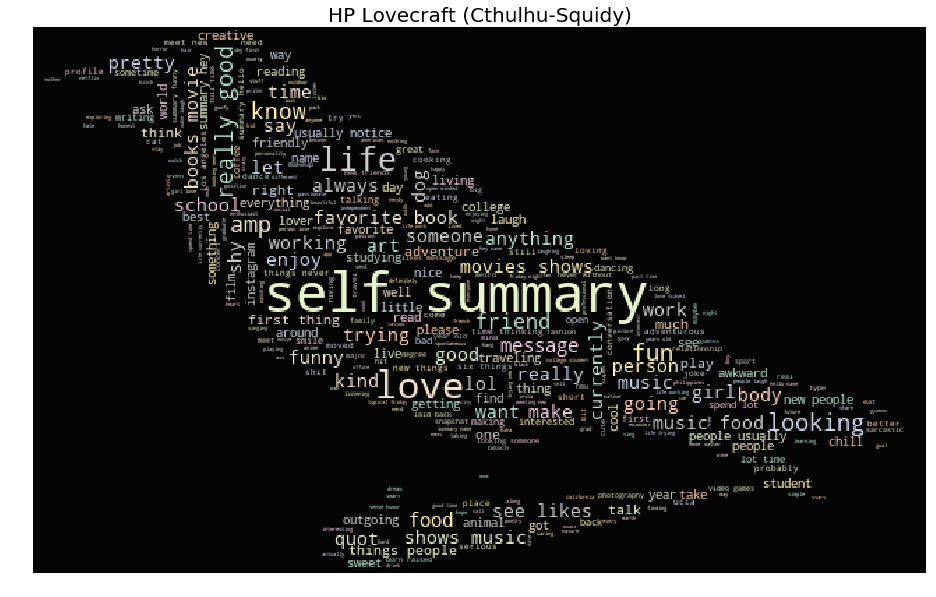

In [126]:
# The wordcloud of octopus for Los Angeles, CA
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(LA))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')